In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.sanity import *

from src.load_datasets import load_air_polution_data

from src.utils import (
    show_dataset,
    show_series,
    plot_metrics,
    test_train_split,
    seperate_target,
    plot_tf_training_history,
)

from src.features import (
    create_lag_feature,
    create_datetime_feature,
    create_cyclic_feature,
    create_window_feature,
    drop_null_rows,
)

from src.evaluation import evaluate

In [2]:
np.random.seed(80)
plt.style.use("seaborn-v0_8-darkgrid")
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

%config InlineBackend.figure_format = 'retina'

In [3]:
dataframe = (
    load_air_polution_data()
    .pipe(format_datetime, col="date")
    .pipe(set_index, col="date")
    .pipe(interpolate_column, cols="pollution")
    .pipe(resample_Data, freq="D")
)

print(f"dataframe shape {dataframe.shape}")

print(dataframe.info())

dataframe.head()

format_datetime: DF Shape (43800, 9)
set_index: DF Shape (43800, 8)
interpolate_columns: DF Shape (43800, 8)
resample_Data: DF Shape (1825, 7)
dataframe shape (1825, 7)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1825 entries, 2010-01-02 to 2014-12-31
Freq: D
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  1825 non-null   float64
 1   dewp       1825 non-null   float64
 2   temp       1825 non-null   float64
 3   press      1825 non-null   float64
 4   wnd_spd    1825 non-null   float64
 5   snow       1825 non-null   float64
 6   rain       1825 non-null   float64
dtypes: float64(7)
memory usage: 114.1 KB
None


,pollution,dewp,temp,press,wnd_spd,snow,rain
date,,,,,,,
2010-01-02,145.958333,-8.500000,-5.125000,1024.750000,24.860000,0.708333,0.0
2010-01-03,78.833333,-10.125000,-8.541667,1022.791667,70.937917,14.166667,0.0
2010-01-04,31.333333,-20.875000,-11.500000,1029.291667,111.160833,0.000000,0.0
2010-01-05,42.458333,-24.583333,-14.458333,1033.625000,56.920000,0.000000,0.0
2010-01-06,56.416667,-23.708333,-12.541667,1033.750000,18.511667,0.000000,0.0


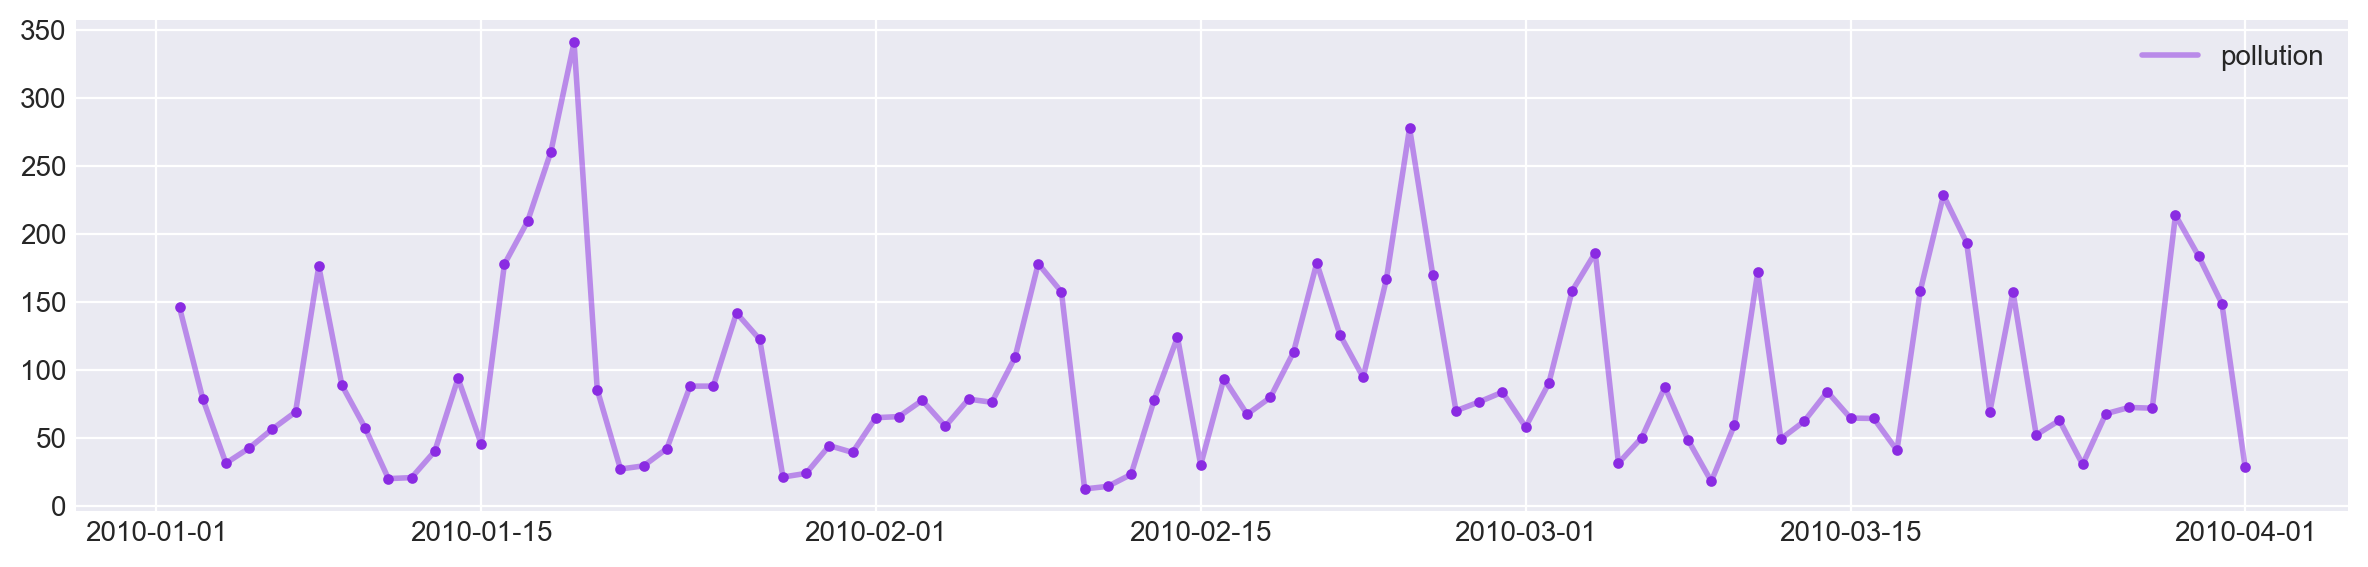

In [4]:
show_dataset(dataframe[:90], columns=["pollution"])

In [5]:
DT_FEATURES = [
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "dayofmonth",
    "weekofyear",
    "dayofweek",
    "is_week_end",
    "is_week_day",
]
CYCLIC_FEATURE = ["day", "month", "year"]
LAGS = [1, 2]
FEATURE_WINDOW_LEN = 3

TARGET_COLUMN = "pollution"
TEST_SIZE = 30

In [6]:
print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

train_data, test_data = test_train_split(df_feat, test_size=TEST_SIZE)

print(f"Train Size after Test_Train Split: {train_data.shape}")
print(f"Test  Size after Test_Train Split: {test_data.shape} ", end="\n\n")

train_x, train_y = seperate_target(train_data, TARGET_COLUMN)
test_x, test_y = seperate_target(test_data, TARGET_COLUMN)

print(f"train_x shape after seperate_target {train_x.shape}")
print(f"train_y shape after seperate_target {train_y.shape}")
print(f"test_x  shape after seperate_target {test_x.shape}")
print(f"test_y  shape after seperate_target {test_y.shape}")

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

Train Size after Test_Train Split: (1792, 26)
Test  Size after Test_Train Split: (30, 26) 

train_x shape after seperate_target (1792, 25)
train_y shape after seperate_target (1792, 1)
test_x  shape after seperate_target (30, 25)
test_y  shape after seperate_target (30, 1)


In [7]:
resultsDict = {}
predictionsDF = pd.DataFrame(index=test_x.index)

### KNeighborsRegressor

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model_name = "KNeighborsRegressor"

estimator_ = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            KNeighborsRegressor(n_neighbors=2),
        ),
    ]
)

param_grid = {"regressor__n_neighbors": [2, 3, 5, 7, 12, 15]}

cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV 1/3] END .........regressor__n_neighbors=2;, score=-0.217 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=2;, score=-0.144 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=2;, score=0.110 total time=   0.0s
[CV 1/3] END .........regressor__n_neighbors=3;, score=-0.016 total time=   0.0s
[CV 2/3] END .........regressor__n_neighbors=3;, score=-0.018 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=3;, score=0.135 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=5;, score=0.053 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=5;, score=0.057 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=5;, score=0.214 total time=   0.0s
[CV 1/3] END ..........regressor__n_neighbors=7;, score=0.123 total time=   0.0s
[CV 2/3] END ..........regressor__n_neighbors=7;, score=0.128 total time=   0.0s
[CV 3/3] END ..........regressor__n_neighbors=7;,

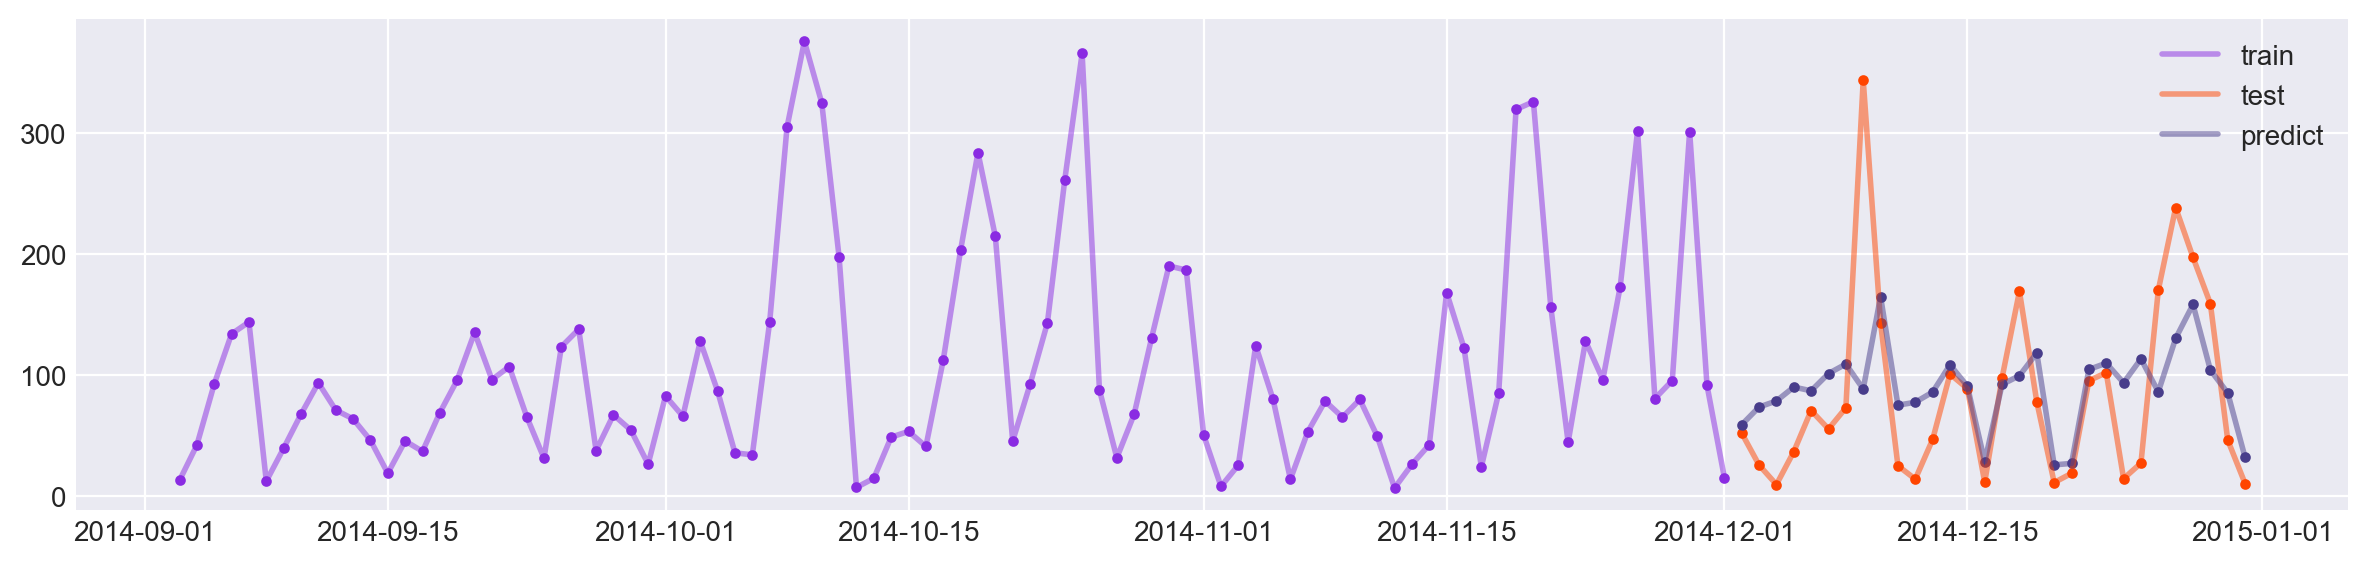

In [9]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Ridge Model

In [10]:
from sklearn.linear_model import BayesianRidge

model, yhat, model_name = None, None, None
model_name = "BayesianRidge"

model = Pipeline(
    [
        ("scaler", StandardScaler()),
        (
            "regressor",
            BayesianRidge(fit_intercept=True, verbose=True, compute_score=True),
        ),
    ]
)


model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Convergence after  7  iterations


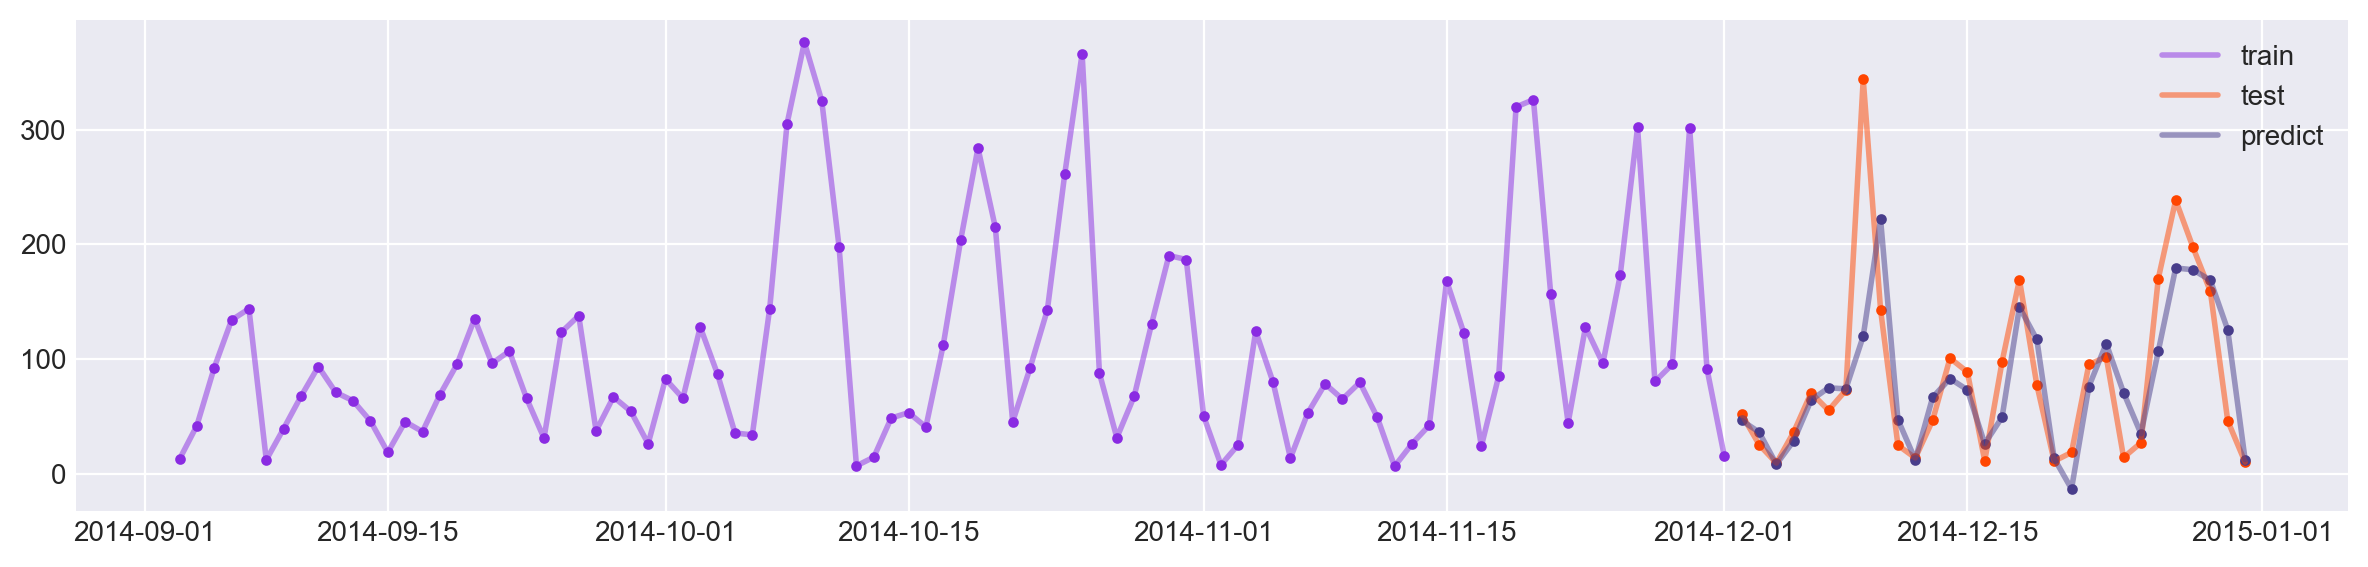

In [11]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LassoCV Regressor

In [12]:
from sklearn.linear_model import LassoCV

model, yhat, model_name = None, None, None

model_name = "LassoCV"

model = Pipeline(
    [("scaler", StandardScaler()), ("regressor", LassoCV(fit_intercept=True))]
)

model.fit(train_x, train_y.to_numpy().flatten())
yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

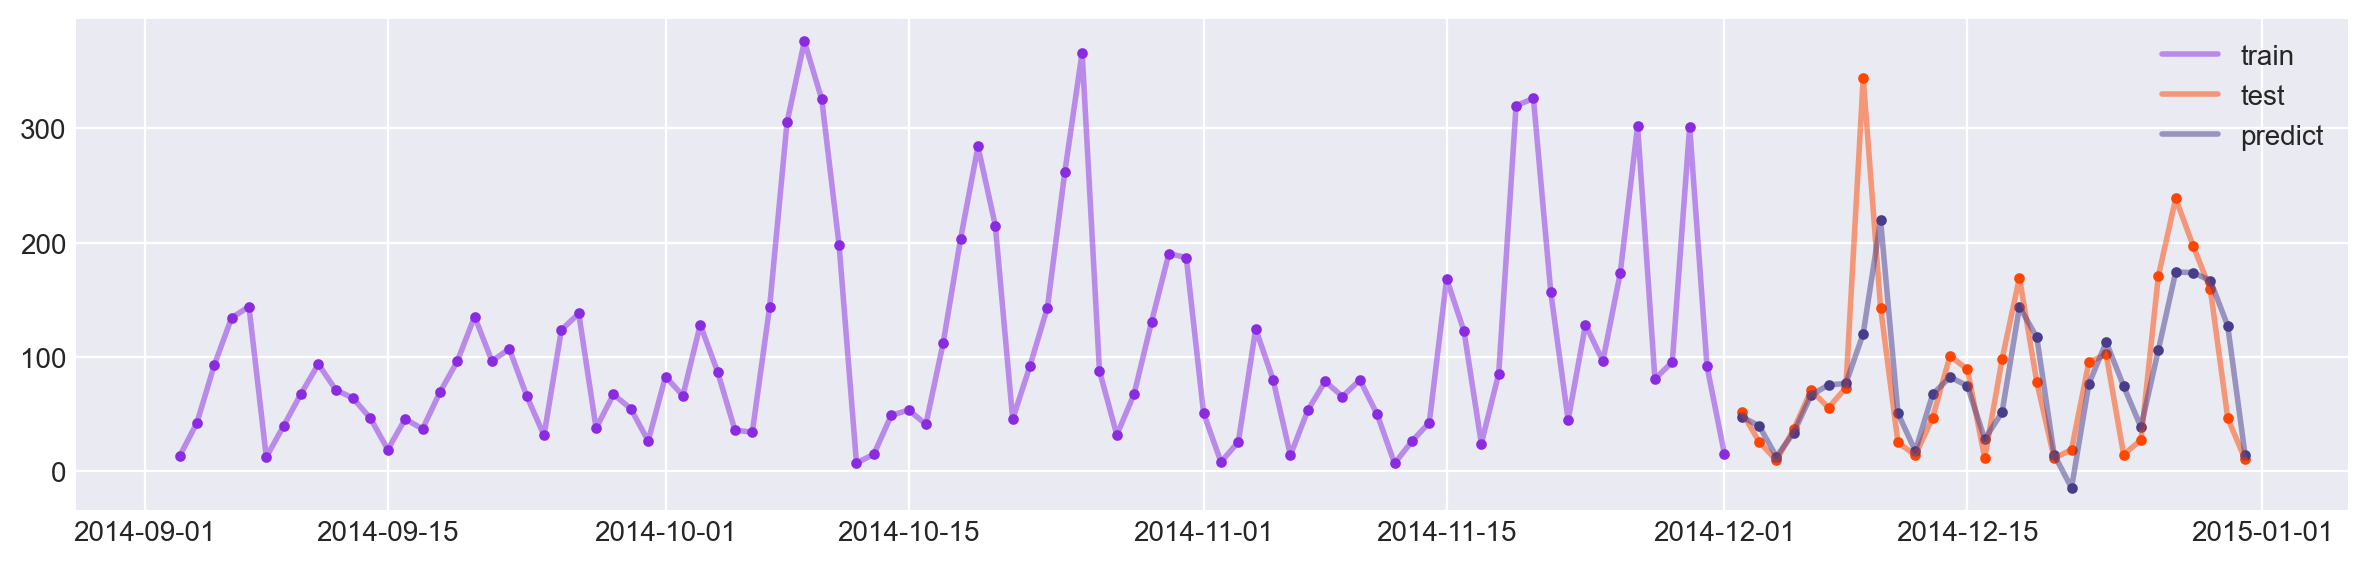

In [13]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### Random Forest Regressor

In [14]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

model, yhat, model_name = None, None, None

model_name = "RandomForestRegressor"

# Best Params {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}

param_grid = {
    #'bootstrap': [True,False],
    # "max_depth": [7, 8, 9],
    # "min_samples_leaf": [2, 3],
    # "min_samples_split": [7, 8],
    # "n_estimators": [300, 500, 600],
    "max_depth": [9],
    "min_samples_leaf": [2],
    "min_samples_split": [7],
    "n_estimators": [500],
}

estimator_ = RandomForestRegressor(random_state=80)


cross_validator = TimeSeriesSplit(n_splits=3)

gsearch = GridSearchCV(
    estimator=estimator_,
    cv=cross_validator,
    param_grid=param_grid,
    refit=True,
    verbose=3,
    n_jobs=1,
)

# gsearch.fit(train_x_scaled, train_y.to_numpy().flatten())


gsearch.fit(train_x, train_y.to_numpy().flatten())

print(gsearch.best_score_, gsearch.best_params_)

model = gsearch.best_estimator_

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)
predictionsDF[model_name] = yhat

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.425 total time=   1.8s
[CV 2/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.481 total time=   6.5s
[CV 3/3] END max_depth=9, min_samples_leaf=2, min_samples_split=7, n_estimators=500;, score=0.662 total time=  14.3s
0.5226139945010286 {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 500}


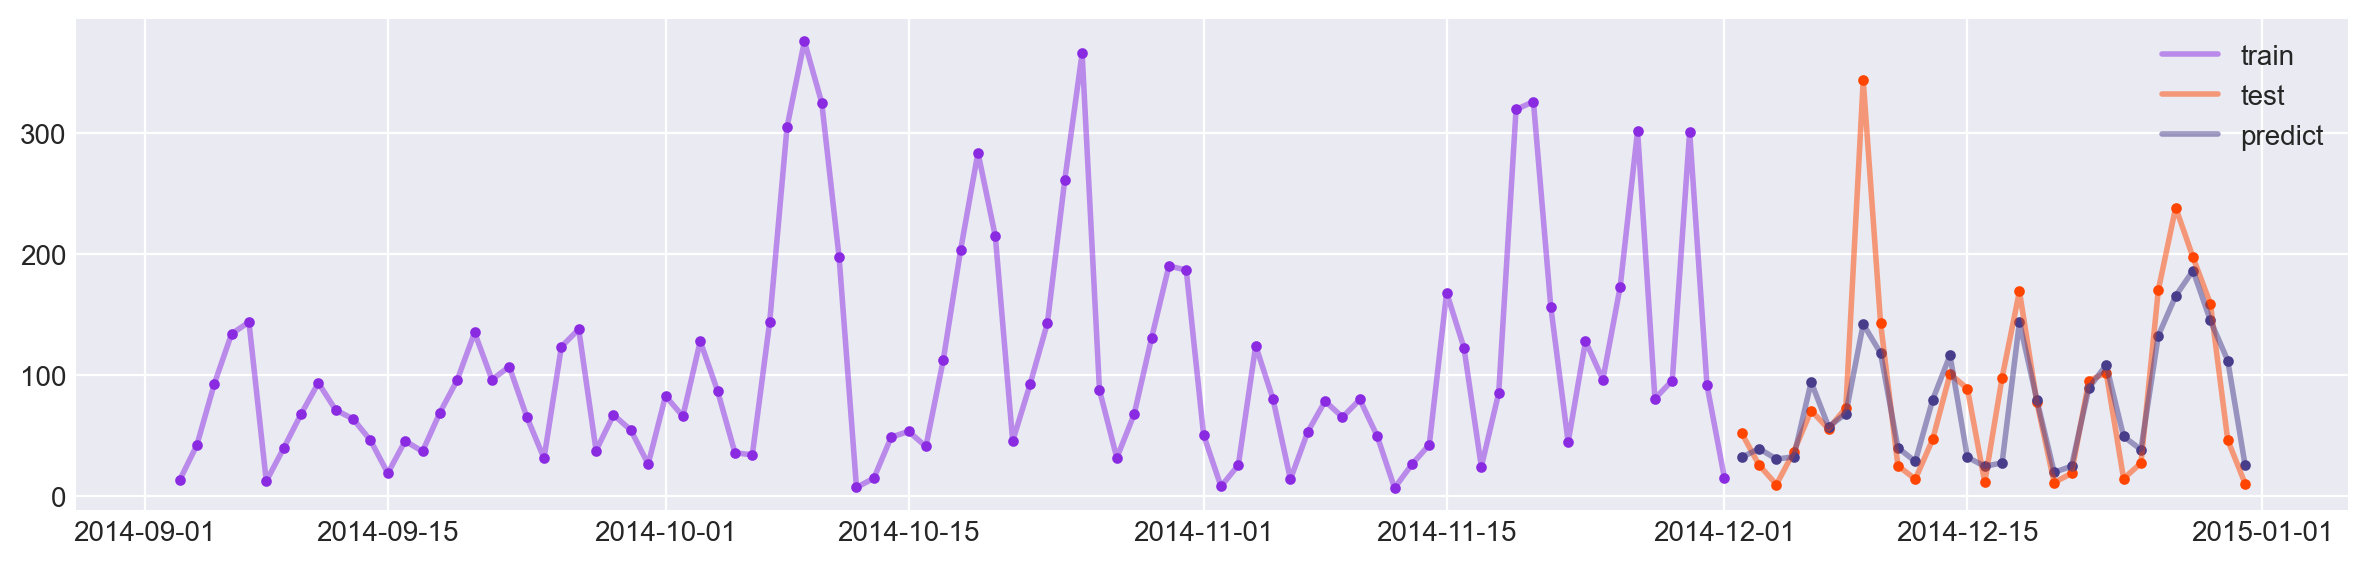

In [15]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### XGB Regressor

[0]	validation_0-mae:97.50973	validation_1-mae:83.00534
[1]	validation_0-mae:96.55928	validation_1-mae:82.33506
[2]	validation_0-mae:95.61940	validation_1-mae:81.60632
[3]	validation_0-mae:94.68772	validation_1-mae:80.94883
[4]	validation_0-mae:93.76711	validation_1-mae:80.19448
[5]	validation_0-mae:92.85529	validation_1-mae:79.48632
[6]	validation_0-mae:91.95232	validation_1-mae:78.76858
[7]	validation_0-mae:91.05879	validation_1-mae:78.07392
[8]	validation_0-mae:90.17566	validation_1-mae:77.33940
[9]	validation_0-mae:89.30134	validation_1-mae:76.66399
[10]	validation_0-mae:88.43599	validation_1-mae:76.01306
[11]	validation_0-mae:87.57977	validation_1-mae:75.46389
[12]	validation_0-mae:86.73529	validation_1-mae:74.90868
[13]	validation_0-mae:85.89699	validation_1-mae:74.30914
[14]	validation_0-mae:85.06747	validation_1-mae:73.62345
[15]	validation_0-mae:84.24746	validation_1-mae:73.03553
[16]	validation_0-mae:83.43748	validation_1-mae:72.44392
[17]	validation_0-mae:82.63781	validation

[143]	validation_0-mae:33.06391	validation_1-mae:37.35965
[144]	validation_0-mae:32.90550	validation_1-mae:37.27800
[145]	validation_0-mae:32.74761	validation_1-mae:37.15448
[146]	validation_0-mae:32.59303	validation_1-mae:37.02234
[147]	validation_0-mae:32.42968	validation_1-mae:36.89276
[148]	validation_0-mae:32.28026	validation_1-mae:36.73666
[149]	validation_0-mae:32.13282	validation_1-mae:36.65348
[150]	validation_0-mae:31.98504	validation_1-mae:36.52175
[151]	validation_0-mae:31.82782	validation_1-mae:36.40379
[152]	validation_0-mae:31.67273	validation_1-mae:36.27022
[153]	validation_0-mae:31.53991	validation_1-mae:36.18940
[154]	validation_0-mae:31.40332	validation_1-mae:36.12418
[155]	validation_0-mae:31.25538	validation_1-mae:36.00245
[156]	validation_0-mae:31.12581	validation_1-mae:35.92681
[157]	validation_0-mae:30.99050	validation_1-mae:35.77935
[158]	validation_0-mae:30.86407	validation_1-mae:35.66958
[159]	validation_0-mae:30.74159	validation_1-mae:35.57865
[160]	validati

[285]	validation_0-mae:21.96461	validation_1-mae:28.92291
[286]	validation_0-mae:21.92722	validation_1-mae:28.89532
[287]	validation_0-mae:21.88900	validation_1-mae:28.87230
[288]	validation_0-mae:21.85649	validation_1-mae:28.84663
[289]	validation_0-mae:21.82633	validation_1-mae:28.81614
[290]	validation_0-mae:21.79039	validation_1-mae:28.79272
[291]	validation_0-mae:21.75673	validation_1-mae:28.76904
[292]	validation_0-mae:21.72550	validation_1-mae:28.75926
[293]	validation_0-mae:21.68047	validation_1-mae:28.75286
[294]	validation_0-mae:21.65019	validation_1-mae:28.74210
[295]	validation_0-mae:21.61000	validation_1-mae:28.69903
[296]	validation_0-mae:21.58113	validation_1-mae:28.67040
[297]	validation_0-mae:21.54666	validation_1-mae:28.64441
[298]	validation_0-mae:21.51588	validation_1-mae:28.62245
[299]	validation_0-mae:21.47477	validation_1-mae:28.59915
[300]	validation_0-mae:21.44560	validation_1-mae:28.58709
[301]	validation_0-mae:21.41305	validation_1-mae:28.56397
[302]	validati

[426]	validation_0-mae:17.74167	validation_1-mae:26.38499
[427]	validation_0-mae:17.72942	validation_1-mae:26.37887
[428]	validation_0-mae:17.70607	validation_1-mae:26.33712
[429]	validation_0-mae:17.67656	validation_1-mae:26.30694
[430]	validation_0-mae:17.64687	validation_1-mae:26.29432
[431]	validation_0-mae:17.63718	validation_1-mae:26.29432
[432]	validation_0-mae:17.61469	validation_1-mae:26.24500
[433]	validation_0-mae:17.58162	validation_1-mae:26.25084
[434]	validation_0-mae:17.57039	validation_1-mae:26.25084
[435]	validation_0-mae:17.54638	validation_1-mae:26.25326
[436]	validation_0-mae:17.52734	validation_1-mae:26.26097
[437]	validation_0-mae:17.50406	validation_1-mae:26.23310
[438]	validation_0-mae:17.48055	validation_1-mae:26.22793
[439]	validation_0-mae:17.46936	validation_1-mae:26.23052
[440]	validation_0-mae:17.44746	validation_1-mae:26.23172
[441]	validation_0-mae:17.43607	validation_1-mae:26.22677
[442]	validation_0-mae:17.40017	validation_1-mae:26.22614
[443]	validati

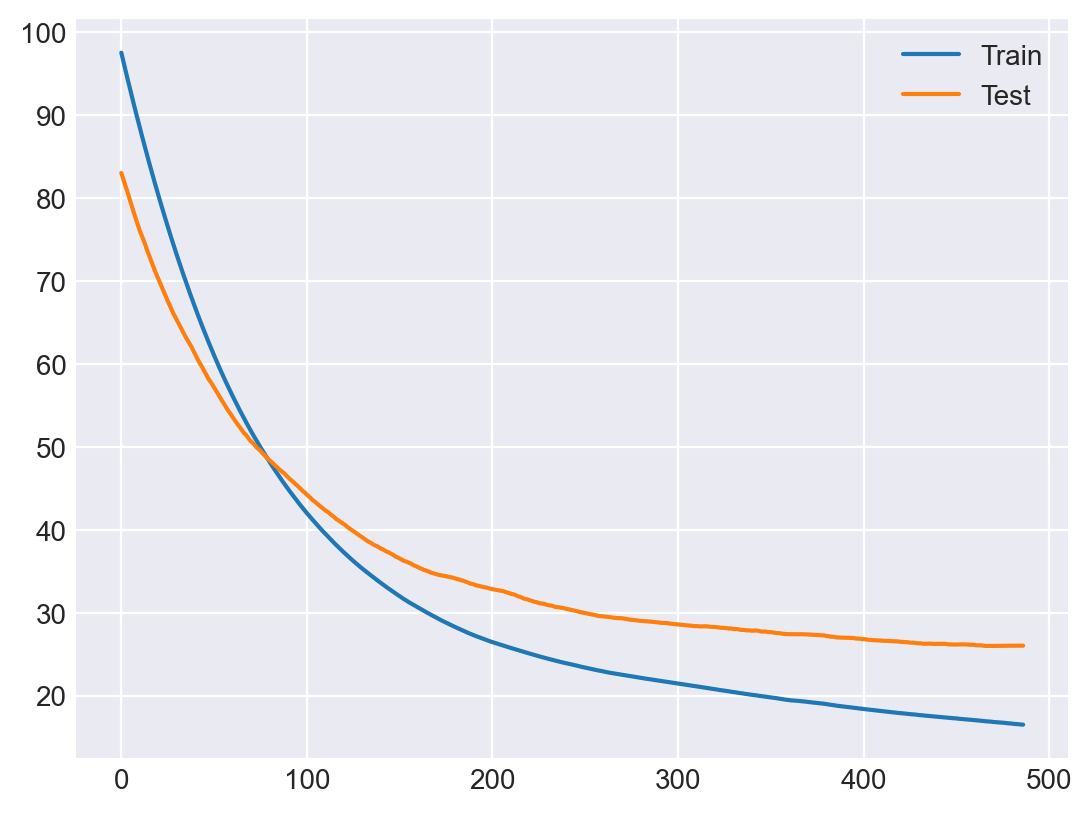

In [16]:
import xgboost as xgb

model, yhat, model_name = None, None, None

model_name = "XGBRegressor"

model = xgb.XGBRegressor(
    objective="reg:squarederror",
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    tree_method="hist",
    early_stopping_rounds=20,
    eval_metric="mae",
    random_state=1,
)

model.fit(
    train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], verbose=True
)

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

# resultsDF.head()

fig, ax = plt.subplots()
epochs = len(model.evals_result()["validation_0"]["mae"])
x_axis = range(0, epochs)
ax.plot(x_axis, model.evals_result()["validation_0"]["mae"], label="Train")
ax.plot(x_axis, model.evals_result()["validation_1"]["mae"], label="Test")
ax.legend()

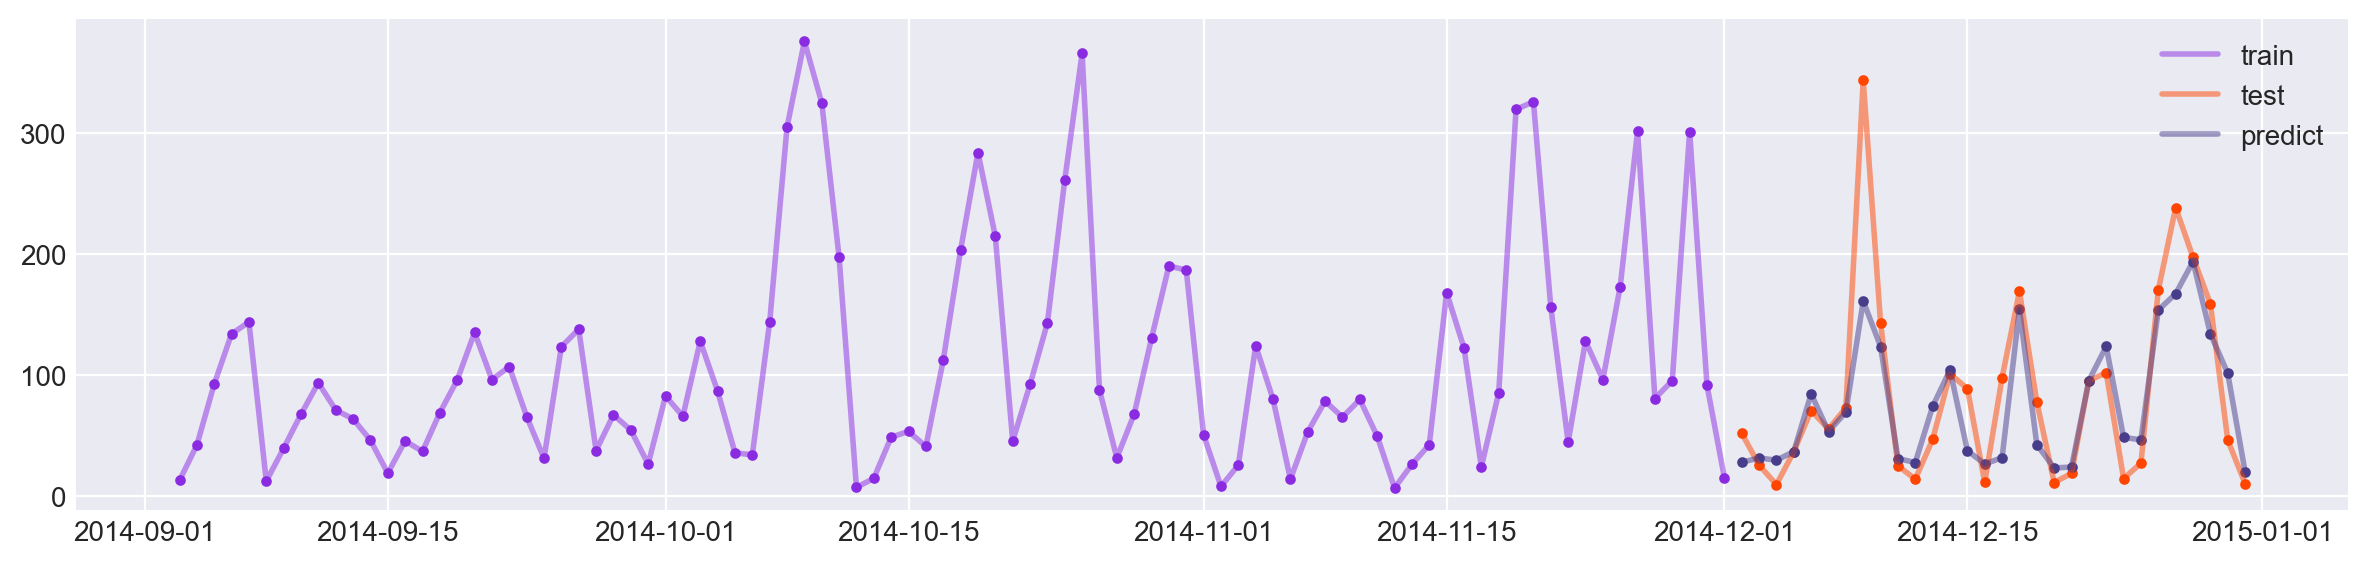

In [17]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### LGBM

In [18]:
import lightgbm as lgb

model, yhat, model_name = None, None, None

model_name = "LGBMRegressor"

hyper_params = {
    "task": "train",
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": ["mae", "l2"],
    "learning_rate": 0.005,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.7,
    "bagging_freq": 10,
    "verbose": 0,
    "max_depth": 8,
    "num_leaves": 128,
    "max_bin": 512,
    "num_iterations": 10000,
}

model = lgb.LGBMRegressor()

model.fit(
    train_x,
    train_y,
    eval_set=[(train_x, train_y), (test_x, test_y)],
    eval_metric="mae",
    callbacks=[lgb.early_stopping(stopping_rounds=5000), lgb.log_evaluation()],
)


yhat = model.predict(test_x, num_iteration=model.best_iteration_)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

[1]	training's l1: 54.7576	training's l2: 5276.63	valid_1's l1: 59.6703	valid_1's l2: 5616.43
Training until validation scores don't improve for 5000 rounds
[2]	training's l1: 51.8594	training's l2: 4693.06	valid_1's l1: 56.4475	valid_1's l2: 5112.65
[3]	training's l1: 49.2914	training's l2: 4213.92	valid_1's l1: 54.1865	valid_1's l2: 4747.06
[4]	training's l1: 46.9018	training's l2: 3792.44	valid_1's l1: 51.5339	valid_1's l2: 4424.46
[5]	training's l1: 44.8834	training's l2: 3446.95	valid_1's l1: 49.7896	valid_1's l2: 4148.39
[6]	training's l1: 43.0448	training's l2: 3151.84	valid_1's l1: 46.8218	valid_1's l2: 3814.67
[7]	training's l1: 41.2716	training's l2: 2884.91	valid_1's l1: 45.3892	valid_1's l2: 3662.31
[8]	training's l1: 39.7325	training's l2: 2665.5	valid_1's l1: 43.2762	valid_1's l2: 3445.2
[9]	training's l1: 38.3548	training's l2: 2478.16	valid_1's l1: 41.2268	valid_1's l2: 3218.93
[10]	training's l1: 37.1046	training's l2: 2314.8	valid_1's l1: 39.8503	valid_1's l2: 3094.99

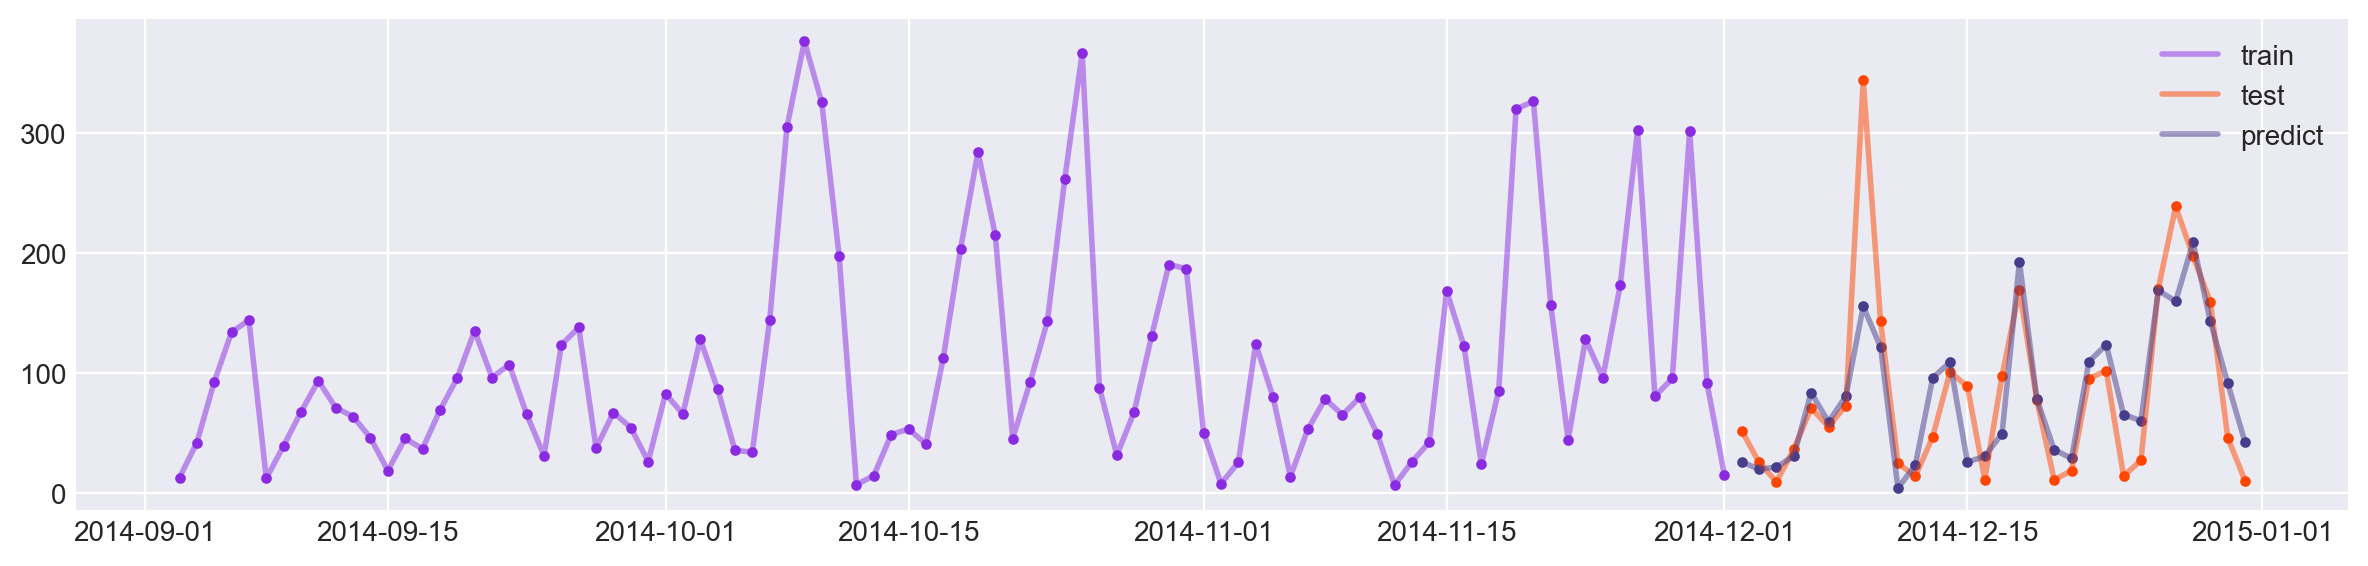

In [19]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

### CatBoost

In [20]:
import catboost

model, yhat, model_name = None, None, None

model_name = "CatBoostRegressor"

model = catboost.CatBoostRegressor(learning_rate=0.1, depth=4, iterations=1000)

train_pool = catboost.Pool(train_x, train_y)
test_pool = catboost.Pool(test_x, test_y)

grid = {
    #    'learning_rate': [0.03, 0.1],
    #    'depth':[4, 6, 10],
    #    'l2_leaf_reg': [1, 3, 5, 7, 9]
    "l2_leaf_reg": [3, 5]
}

grid_search_results = model.grid_search(
    grid, train_pool, shuffle=False, verbose=3, refit=True, plot=False
)


print(grid_search_results["params"])

yhat = model.predict(test_x)

resultsDict[model_name] = evaluate(test_y[TARGET_COLUMN].to_numpy(), yhat)

predictionsDF[model_name] = yhat

0:	learn: 116.3415849	test: 119.0673866	best: 119.0673866 (0)	total: 143ms	remaining: 2m 23s
1:	learn: 108.9416806	test: 111.7800186	best: 111.7800186 (1)	total: 147ms	remaining: 1m 13s
2:	learn: 102.5520444	test: 105.2861793	best: 105.2861793 (2)	total: 150ms	remaining: 50s
3:	learn: 96.5702719	test: 99.2383515	best: 99.2383515 (3)	total: 155ms	remaining: 38.5s
4:	learn: 91.2369377	test: 94.1273900	best: 94.1273900 (4)	total: 157ms	remaining: 31.2s
5:	learn: 86.5355834	test: 89.6931726	best: 89.6931726 (5)	total: 164ms	remaining: 27.1s
6:	learn: 81.9816518	test: 84.9619819	best: 84.9619819 (6)	total: 171ms	remaining: 24.2s
7:	learn: 78.7406772	test: 82.0528803	best: 82.0528803 (7)	total: 183ms	remaining: 22.7s
8:	learn: 75.1999775	test: 78.4176663	best: 78.4176663 (8)	total: 196ms	remaining: 21.5s
9:	learn: 72.6767422	test: 76.0471712	best: 76.0471712 (9)	total: 212ms	remaining: 21s
10:	learn: 70.1287532	test: 73.5151065	best: 73.5151065 (10)	total: 230ms	remaining: 20.7s
11:	learn: 6

102:	learn: 39.4092203	test: 44.8859034	best: 44.8859034 (102)	total: 1.45s	remaining: 12.6s
103:	learn: 39.3012044	test: 44.9358907	best: 44.8859034 (102)	total: 1.47s	remaining: 12.7s
104:	learn: 39.2290033	test: 44.9380728	best: 44.8859034 (102)	total: 1.5s	remaining: 12.8s
105:	learn: 39.1365442	test: 44.9432071	best: 44.8859034 (102)	total: 1.53s	remaining: 12.9s
106:	learn: 39.0152104	test: 44.7777830	best: 44.7777830 (106)	total: 1.55s	remaining: 12.9s
107:	learn: 38.9513500	test: 44.7805672	best: 44.7777830 (106)	total: 1.56s	remaining: 12.9s
108:	learn: 38.8518328	test: 44.7611217	best: 44.7611217 (108)	total: 1.58s	remaining: 12.9s
109:	learn: 38.7500059	test: 44.6969651	best: 44.6969651 (109)	total: 1.59s	remaining: 12.9s
110:	learn: 38.6406794	test: 44.7227720	best: 44.6969651 (109)	total: 1.6s	remaining: 12.8s
111:	learn: 38.5356882	test: 44.6814574	best: 44.6814574 (111)	total: 1.61s	remaining: 12.8s
112:	learn: 38.4709121	test: 44.7104901	best: 44.6814574 (111)	total: 1.

198:	learn: 32.2312541	test: 43.1834854	best: 43.1464953 (190)	total: 2.94s	remaining: 11.9s
199:	learn: 32.1847133	test: 43.1585872	best: 43.1464953 (190)	total: 2.95s	remaining: 11.8s
200:	learn: 32.1110381	test: 43.2106496	best: 43.1464953 (190)	total: 2.95s	remaining: 11.7s
201:	learn: 32.0453924	test: 43.2048089	best: 43.1464953 (190)	total: 2.95s	remaining: 11.7s
202:	learn: 31.9663362	test: 43.1411400	best: 43.1411400 (202)	total: 2.96s	remaining: 11.6s
203:	learn: 31.9231794	test: 43.1904827	best: 43.1411400 (202)	total: 2.96s	remaining: 11.5s
204:	learn: 31.8361412	test: 43.1820450	best: 43.1411400 (202)	total: 2.96s	remaining: 11.5s
205:	learn: 31.7782459	test: 43.1796269	best: 43.1411400 (202)	total: 2.96s	remaining: 11.4s
206:	learn: 31.7204832	test: 43.1334607	best: 43.1334607 (206)	total: 2.97s	remaining: 11.4s
207:	learn: 31.6826176	test: 43.0882551	best: 43.0882551 (207)	total: 2.99s	remaining: 11.4s
208:	learn: 31.6287820	test: 43.1051022	best: 43.0882551 (207)	total: 

296:	learn: 27.6555136	test: 42.5671191	best: 42.5503016 (295)	total: 4.33s	remaining: 10.2s
297:	learn: 27.6311153	test: 42.5622792	best: 42.5503016 (295)	total: 4.35s	remaining: 10.2s
298:	learn: 27.5862542	test: 42.5512580	best: 42.5503016 (295)	total: 4.36s	remaining: 10.2s
299:	learn: 27.5325291	test: 42.5153141	best: 42.5153141 (299)	total: 4.37s	remaining: 10.2s
300:	learn: 27.4847604	test: 42.5417799	best: 42.5153141 (299)	total: 4.39s	remaining: 10.2s
301:	learn: 27.4472266	test: 42.4846684	best: 42.4846684 (301)	total: 4.41s	remaining: 10.2s
302:	learn: 27.4271677	test: 42.4812207	best: 42.4812207 (302)	total: 4.42s	remaining: 10.2s
303:	learn: 27.3676285	test: 42.5222041	best: 42.4812207 (302)	total: 4.43s	remaining: 10.1s
304:	learn: 27.3413823	test: 42.5307017	best: 42.4812207 (302)	total: 4.45s	remaining: 10.1s
305:	learn: 27.3203320	test: 42.5252853	best: 42.4812207 (302)	total: 4.46s	remaining: 10.1s
306:	learn: 27.2639106	test: 42.5356913	best: 42.4812207 (302)	total: 

403:	learn: 24.0158988	test: 42.5585744	best: 42.4371523 (384)	total: 5.85s	remaining: 8.63s
404:	learn: 23.9700254	test: 42.5482555	best: 42.4371523 (384)	total: 5.85s	remaining: 8.6s
405:	learn: 23.9296717	test: 42.5135264	best: 42.4371523 (384)	total: 5.86s	remaining: 8.57s
406:	learn: 23.8852394	test: 42.5245646	best: 42.4371523 (384)	total: 5.86s	remaining: 8.54s
407:	learn: 23.8617398	test: 42.5415519	best: 42.4371523 (384)	total: 5.86s	remaining: 8.51s
408:	learn: 23.8324780	test: 42.5498632	best: 42.4371523 (384)	total: 5.87s	remaining: 8.47s
409:	learn: 23.8073594	test: 42.5593885	best: 42.4371523 (384)	total: 5.87s	remaining: 8.44s
410:	learn: 23.8010627	test: 42.5713921	best: 42.4371523 (384)	total: 5.87s	remaining: 8.41s
411:	learn: 23.7754603	test: 42.5837364	best: 42.4371523 (384)	total: 5.87s	remaining: 8.38s
412:	learn: 23.7443469	test: 42.5988974	best: 42.4371523 (384)	total: 5.88s	remaining: 8.35s
413:	learn: 23.7221193	test: 42.6096388	best: 42.4371523 (384)	total: 5

498:	learn: 21.4381663	test: 42.4735639	best: 42.4371523 (384)	total: 7.12s	remaining: 7.15s
499:	learn: 21.4011613	test: 42.4793208	best: 42.4371523 (384)	total: 7.12s	remaining: 7.12s
500:	learn: 21.3671588	test: 42.4863789	best: 42.4371523 (384)	total: 7.13s	remaining: 7.1s
501:	learn: 21.3541591	test: 42.4806650	best: 42.4371523 (384)	total: 7.13s	remaining: 7.07s
502:	learn: 21.3222298	test: 42.5013311	best: 42.4371523 (384)	total: 7.13s	remaining: 7.05s
503:	learn: 21.2995224	test: 42.5251898	best: 42.4371523 (384)	total: 7.13s	remaining: 7.02s
504:	learn: 21.2688987	test: 42.5131282	best: 42.4371523 (384)	total: 7.14s	remaining: 7s
505:	learn: 21.2574973	test: 42.5052788	best: 42.4371523 (384)	total: 7.15s	remaining: 6.98s
506:	learn: 21.2145968	test: 42.4971424	best: 42.4371523 (384)	total: 7.18s	remaining: 6.98s
507:	learn: 21.2041599	test: 42.5023356	best: 42.4371523 (384)	total: 7.21s	remaining: 6.98s
508:	learn: 21.1758362	test: 42.5154015	best: 42.4371523 (384)	total: 7.24

606:	learn: 18.9559559	test: 42.4857025	best: 42.3617562 (546)	total: 8.73s	remaining: 5.65s
607:	learn: 18.9456376	test: 42.4934696	best: 42.3617562 (546)	total: 8.75s	remaining: 5.64s
608:	learn: 18.9293143	test: 42.4790814	best: 42.3617562 (546)	total: 8.77s	remaining: 5.63s
609:	learn: 18.9152806	test: 42.4855038	best: 42.3617562 (546)	total: 8.79s	remaining: 5.62s
610:	learn: 18.9006144	test: 42.4968971	best: 42.3617562 (546)	total: 8.81s	remaining: 5.61s
611:	learn: 18.8787521	test: 42.5146312	best: 42.3617562 (546)	total: 8.83s	remaining: 5.59s
612:	learn: 18.8712418	test: 42.5192474	best: 42.3617562 (546)	total: 8.84s	remaining: 5.58s
613:	learn: 18.8442261	test: 42.5389548	best: 42.3617562 (546)	total: 8.86s	remaining: 5.57s
614:	learn: 18.8397611	test: 42.5349798	best: 42.3617562 (546)	total: 8.87s	remaining: 5.55s
615:	learn: 18.8006791	test: 42.5245458	best: 42.3617562 (546)	total: 8.88s	remaining: 5.54s
616:	learn: 18.7875157	test: 42.5322162	best: 42.3617562 (546)	total: 

701:	learn: 17.2640342	test: 42.4549019	best: 42.3617562 (546)	total: 10s	remaining: 4.25s
702:	learn: 17.2576899	test: 42.4523487	best: 42.3617562 (546)	total: 10s	remaining: 4.23s
703:	learn: 17.2346508	test: 42.4556143	best: 42.3617562 (546)	total: 10s	remaining: 4.21s
704:	learn: 17.2308499	test: 42.4559495	best: 42.3617562 (546)	total: 10.1s	remaining: 4.21s
705:	learn: 17.2126969	test: 42.4479038	best: 42.3617562 (546)	total: 10.1s	remaining: 4.19s
706:	learn: 17.2002736	test: 42.4428665	best: 42.3617562 (546)	total: 10.1s	remaining: 4.18s
707:	learn: 17.1754147	test: 42.4422394	best: 42.3617562 (546)	total: 10.1s	remaining: 4.16s
708:	learn: 17.1449598	test: 42.4426357	best: 42.3617562 (546)	total: 10.1s	remaining: 4.15s
709:	learn: 17.1292123	test: 42.4368725	best: 42.3617562 (546)	total: 10.2s	remaining: 4.14s
710:	learn: 17.1142692	test: 42.4517905	best: 42.3617562 (546)	total: 10.2s	remaining: 4.14s
711:	learn: 17.1015378	test: 42.4431315	best: 42.3617562 (546)	total: 10.2s	

797:	learn: 15.6623723	test: 42.4009427	best: 42.3198515 (787)	total: 11.5s	remaining: 2.91s
798:	learn: 15.6400620	test: 42.4057484	best: 42.3198515 (787)	total: 11.5s	remaining: 2.9s
799:	learn: 15.6263604	test: 42.4026447	best: 42.3198515 (787)	total: 11.5s	remaining: 2.88s
800:	learn: 15.5961947	test: 42.3864766	best: 42.3198515 (787)	total: 11.5s	remaining: 2.86s
801:	learn: 15.5868424	test: 42.3854426	best: 42.3198515 (787)	total: 11.5s	remaining: 2.84s
802:	learn: 15.5707833	test: 42.3776597	best: 42.3198515 (787)	total: 11.5s	remaining: 2.83s
803:	learn: 15.5487599	test: 42.3803524	best: 42.3198515 (787)	total: 11.5s	remaining: 2.81s
804:	learn: 15.5428116	test: 42.3971478	best: 42.3198515 (787)	total: 11.5s	remaining: 2.79s
805:	learn: 15.5328243	test: 42.4022271	best: 42.3198515 (787)	total: 11.5s	remaining: 2.78s
806:	learn: 15.5278349	test: 42.3975295	best: 42.3198515 (787)	total: 11.5s	remaining: 2.76s
807:	learn: 15.5109422	test: 42.4043625	best: 42.3198515 (787)	total: 1

898:	learn: 14.1776164	test: 42.4538978	best: 42.3198515 (787)	total: 12.8s	remaining: 1.44s
899:	learn: 14.1676083	test: 42.4581811	best: 42.3198515 (787)	total: 12.8s	remaining: 1.42s
900:	learn: 14.1543118	test: 42.4587632	best: 42.3198515 (787)	total: 12.8s	remaining: 1.41s
901:	learn: 14.1467624	test: 42.4565087	best: 42.3198515 (787)	total: 12.8s	remaining: 1.39s
902:	learn: 14.1375739	test: 42.4565463	best: 42.3198515 (787)	total: 12.8s	remaining: 1.38s
903:	learn: 14.1224007	test: 42.4557928	best: 42.3198515 (787)	total: 12.8s	remaining: 1.36s
904:	learn: 14.1085214	test: 42.4387769	best: 42.3198515 (787)	total: 12.9s	remaining: 1.35s
905:	learn: 14.0933522	test: 42.4349367	best: 42.3198515 (787)	total: 12.9s	remaining: 1.34s
906:	learn: 14.0836412	test: 42.4388475	best: 42.3198515 (787)	total: 12.9s	remaining: 1.32s
907:	learn: 14.0671024	test: 42.4347659	best: 42.3198515 (787)	total: 12.9s	remaining: 1.31s
908:	learn: 14.0623716	test: 42.4328705	best: 42.3198515 (787)	total: 

993:	learn: 12.9674302	test: 42.5691732	best: 42.3198515 (787)	total: 14s	remaining: 84.7ms
994:	learn: 12.9585988	test: 42.5664332	best: 42.3198515 (787)	total: 14s	remaining: 70.5ms
995:	learn: 12.9516771	test: 42.5648439	best: 42.3198515 (787)	total: 14s	remaining: 56.4ms
996:	learn: 12.9431753	test: 42.5574077	best: 42.3198515 (787)	total: 14s	remaining: 42.3ms
997:	learn: 12.9365299	test: 42.5641064	best: 42.3198515 (787)	total: 14.1s	remaining: 28.2ms
998:	learn: 12.9258024	test: 42.5528009	best: 42.3198515 (787)	total: 14.1s	remaining: 14.1ms
999:	learn: 12.9181532	test: 42.5530925	best: 42.3198515 (787)	total: 14.1s	remaining: 0us

bestTest = 42.31985152
bestIteration = 787

0:	loss: 42.3198515	best: 42.3198515 (0)	total: 14.3s	remaining: 14.3s
0:	learn: 116.6343668	test: 119.3940206	best: 119.3940206 (0)	total: 13.8ms	remaining: 13.8s
1:	learn: 109.4690217	test: 112.3602350	best: 112.3602350 (1)	total: 28.4ms	remaining: 14.2s
2:	learn: 103.1605413	test: 106.0172901	best: 106.0

82:	learn: 41.9973099	test: 45.7923751	best: 45.7923751 (82)	total: 1.2s	remaining: 13.2s
83:	learn: 41.8330272	test: 45.6779855	best: 45.6779855 (83)	total: 1.23s	remaining: 13.4s
84:	learn: 41.7596859	test: 45.6725585	best: 45.6725585 (84)	total: 1.25s	remaining: 13.4s
85:	learn: 41.5904334	test: 45.5829850	best: 45.5829850 (85)	total: 1.26s	remaining: 13.4s
86:	learn: 41.4876290	test: 45.5474308	best: 45.5474308 (86)	total: 1.28s	remaining: 13.4s
87:	learn: 41.3765675	test: 45.4816682	best: 45.4816682 (87)	total: 1.3s	remaining: 13.4s
88:	learn: 41.2636560	test: 45.3946805	best: 45.3946805 (88)	total: 1.31s	remaining: 13.4s
89:	learn: 41.0873550	test: 45.3219038	best: 45.3219038 (89)	total: 1.32s	remaining: 13.4s
90:	learn: 40.9960619	test: 45.2749667	best: 45.2749667 (90)	total: 1.35s	remaining: 13.4s
91:	learn: 40.8233550	test: 45.1230259	best: 45.1230259 (91)	total: 1.37s	remaining: 13.6s
92:	learn: 40.7040488	test: 45.0405909	best: 45.0405909 (92)	total: 1.4s	remaining: 13.6s
93

173:	learn: 34.2814882	test: 42.8914558	best: 42.8532523 (167)	total: 2.5s	remaining: 11.9s
174:	learn: 34.1961491	test: 42.7758937	best: 42.7758937 (174)	total: 2.51s	remaining: 11.8s
175:	learn: 34.1237412	test: 42.7538843	best: 42.7538843 (175)	total: 2.51s	remaining: 11.8s
176:	learn: 34.0928278	test: 42.7620999	best: 42.7538843 (175)	total: 2.52s	remaining: 11.7s
177:	learn: 34.0498415	test: 42.7182749	best: 42.7182749 (177)	total: 2.54s	remaining: 11.7s
178:	learn: 33.9910606	test: 42.7219282	best: 42.7182749 (177)	total: 2.55s	remaining: 11.7s
179:	learn: 33.9355224	test: 42.6926709	best: 42.6926709 (179)	total: 2.56s	remaining: 11.7s
180:	learn: 33.8996671	test: 42.7010317	best: 42.6926709 (179)	total: 2.57s	remaining: 11.7s
181:	learn: 33.8165485	test: 42.7138514	best: 42.6926709 (179)	total: 2.6s	remaining: 11.7s
182:	learn: 33.7329905	test: 42.6583891	best: 42.6583891 (182)	total: 2.63s	remaining: 11.7s
183:	learn: 33.6726310	test: 42.6494674	best: 42.6494674 (183)	total: 2.

271:	learn: 29.9774157	test: 41.8724102	best: 41.8389464 (268)	total: 3.78s	remaining: 10.1s
272:	learn: 29.8842118	test: 41.8778086	best: 41.8389464 (268)	total: 3.78s	remaining: 10.1s
273:	learn: 29.8719020	test: 41.8864090	best: 41.8389464 (268)	total: 3.79s	remaining: 10s
274:	learn: 29.8331790	test: 41.8798470	best: 41.8389464 (268)	total: 3.79s	remaining: 9.99s
275:	learn: 29.7957418	test: 41.9072764	best: 41.8389464 (268)	total: 3.79s	remaining: 9.94s
276:	learn: 29.7299677	test: 41.9123941	best: 41.8389464 (268)	total: 3.79s	remaining: 9.9s
277:	learn: 29.6728594	test: 41.8743622	best: 41.8389464 (268)	total: 3.79s	remaining: 9.86s
278:	learn: 29.6257465	test: 41.8545502	best: 41.8389464 (268)	total: 3.8s	remaining: 9.81s
279:	learn: 29.6005318	test: 41.8360558	best: 41.8360558 (279)	total: 3.8s	remaining: 9.77s
280:	learn: 29.5441957	test: 41.8144696	best: 41.8144696 (280)	total: 3.8s	remaining: 9.73s
281:	learn: 29.5040421	test: 41.8166059	best: 41.8144696 (280)	total: 3.81s	

380:	learn: 26.1955193	test: 41.4275459	best: 41.3755769 (372)	total: 5.34s	remaining: 8.69s
381:	learn: 26.1812711	test: 41.4396718	best: 41.3755769 (372)	total: 5.36s	remaining: 8.68s
382:	learn: 26.1603607	test: 41.4436447	best: 41.3755769 (372)	total: 5.38s	remaining: 8.67s
383:	learn: 26.1368373	test: 41.4574278	best: 41.3755769 (372)	total: 5.39s	remaining: 8.65s
384:	learn: 26.1264878	test: 41.4666555	best: 41.3755769 (372)	total: 5.41s	remaining: 8.63s
385:	learn: 26.0951033	test: 41.4546132	best: 41.3755769 (372)	total: 5.43s	remaining: 8.64s
386:	learn: 26.0790221	test: 41.4294627	best: 41.3755769 (372)	total: 5.48s	remaining: 8.67s
387:	learn: 26.0333112	test: 41.4031597	best: 41.3755769 (372)	total: 5.5s	remaining: 8.68s
388:	learn: 26.0058964	test: 41.4011034	best: 41.3755769 (372)	total: 5.52s	remaining: 8.67s
389:	learn: 25.9751719	test: 41.3848543	best: 41.3755769 (372)	total: 5.53s	remaining: 8.65s
390:	learn: 25.9290375	test: 41.3908094	best: 41.3755769 (372)	total: 5

470:	learn: 23.6971211	test: 41.2021171	best: 41.2021171 (470)	total: 6.64s	remaining: 7.46s
471:	learn: 23.6748708	test: 41.1739626	best: 41.1739626 (471)	total: 6.65s	remaining: 7.43s
472:	learn: 23.6316532	test: 41.1477838	best: 41.1477838 (472)	total: 6.65s	remaining: 7.41s
473:	learn: 23.6071269	test: 41.1557864	best: 41.1477838 (472)	total: 6.65s	remaining: 7.38s
474:	learn: 23.5860305	test: 41.1838762	best: 41.1477838 (472)	total: 6.65s	remaining: 7.36s
475:	learn: 23.5678973	test: 41.1872817	best: 41.1477838 (472)	total: 6.66s	remaining: 7.33s
476:	learn: 23.5244553	test: 41.2126851	best: 41.1477838 (472)	total: 6.67s	remaining: 7.31s
477:	learn: 23.4999015	test: 41.2092067	best: 41.1477838 (472)	total: 6.68s	remaining: 7.3s
478:	learn: 23.4631167	test: 41.2129058	best: 41.1477838 (472)	total: 6.7s	remaining: 7.28s
479:	learn: 23.4526993	test: 41.2119848	best: 41.1477838 (472)	total: 6.71s	remaining: 7.27s
480:	learn: 23.4509291	test: 41.2143224	best: 41.1477838 (472)	total: 6.

566:	learn: 21.5467946	test: 41.1294422	best: 41.1261361 (561)	total: 7.92s	remaining: 6.05s
567:	learn: 21.5259048	test: 41.1446988	best: 41.1261361 (561)	total: 7.92s	remaining: 6.03s
568:	learn: 21.4958182	test: 41.1467373	best: 41.1261361 (561)	total: 7.93s	remaining: 6s
569:	learn: 21.4718047	test: 41.1555704	best: 41.1261361 (561)	total: 7.93s	remaining: 5.98s
570:	learn: 21.4674192	test: 41.1559945	best: 41.1261361 (561)	total: 7.93s	remaining: 5.96s
571:	learn: 21.4535166	test: 41.1688675	best: 41.1261361 (561)	total: 7.94s	remaining: 5.94s
572:	learn: 21.4370251	test: 41.1458735	best: 41.1261361 (561)	total: 7.94s	remaining: 5.92s
573:	learn: 21.4230924	test: 41.1465100	best: 41.1261361 (561)	total: 7.94s	remaining: 5.9s
574:	learn: 21.3970114	test: 41.1694340	best: 41.1261361 (561)	total: 7.95s	remaining: 5.87s
575:	learn: 21.3814934	test: 41.1677986	best: 41.1261361 (561)	total: 7.95s	remaining: 5.85s
576:	learn: 21.3506435	test: 41.1564469	best: 41.1261361 (561)	total: 7.95

660:	learn: 19.5795910	test: 40.9273866	best: 40.9147988 (658)	total: 9.23s	remaining: 4.73s
661:	learn: 19.5612028	test: 40.9375738	best: 40.9147988 (658)	total: 9.23s	remaining: 4.71s
662:	learn: 19.5412888	test: 40.9333878	best: 40.9147988 (658)	total: 9.23s	remaining: 4.69s
663:	learn: 19.5315730	test: 40.9308928	best: 40.9147988 (658)	total: 9.23s	remaining: 4.67s
664:	learn: 19.5093857	test: 40.9085263	best: 40.9085263 (664)	total: 9.24s	remaining: 4.65s
665:	learn: 19.4819732	test: 40.8977338	best: 40.8977338 (665)	total: 9.24s	remaining: 4.63s
666:	learn: 19.4558632	test: 40.8920609	best: 40.8920609 (666)	total: 9.24s	remaining: 4.61s
667:	learn: 19.4414730	test: 40.8755167	best: 40.8755167 (667)	total: 9.24s	remaining: 4.59s
668:	learn: 19.4061752	test: 40.8796844	best: 40.8755167 (667)	total: 9.24s	remaining: 4.57s
669:	learn: 19.3812418	test: 40.8818813	best: 40.8755167 (667)	total: 9.24s	remaining: 4.55s
670:	learn: 19.3789661	test: 40.8817757	best: 40.8755167 (667)	total: 

753:	learn: 17.9477238	test: 40.9431063	best: 40.8064485 (710)	total: 10.1s	remaining: 3.29s
754:	learn: 17.9272354	test: 40.9448584	best: 40.8064485 (710)	total: 10.1s	remaining: 3.28s
755:	learn: 17.9062177	test: 40.9406792	best: 40.8064485 (710)	total: 10.1s	remaining: 3.26s
756:	learn: 17.8891172	test: 40.9141824	best: 40.8064485 (710)	total: 10.1s	remaining: 3.24s
757:	learn: 17.8775245	test: 40.9149688	best: 40.8064485 (710)	total: 10.1s	remaining: 3.23s
758:	learn: 17.8506218	test: 40.8868729	best: 40.8064485 (710)	total: 10.1s	remaining: 3.21s
759:	learn: 17.8424083	test: 40.8941915	best: 40.8064485 (710)	total: 10.1s	remaining: 3.19s
760:	learn: 17.8201274	test: 40.9028223	best: 40.8064485 (710)	total: 10.1s	remaining: 3.18s
761:	learn: 17.7971031	test: 40.9060614	best: 40.8064485 (710)	total: 10.2s	remaining: 3.17s
762:	learn: 17.7894822	test: 40.9096288	best: 40.8064485 (710)	total: 10.2s	remaining: 3.16s
763:	learn: 17.7754905	test: 40.8984955	best: 40.8064485 (710)	total: 

848:	learn: 16.4036119	test: 40.8435992	best: 40.8027631 (800)	total: 11.9s	remaining: 2.11s
849:	learn: 16.3705505	test: 40.8562011	best: 40.8027631 (800)	total: 11.9s	remaining: 2.1s
850:	learn: 16.3588190	test: 40.8569055	best: 40.8027631 (800)	total: 11.9s	remaining: 2.09s
851:	learn: 16.3374835	test: 40.8483209	best: 40.8027631 (800)	total: 11.9s	remaining: 2.07s
852:	learn: 16.3336022	test: 40.8496902	best: 40.8027631 (800)	total: 12s	remaining: 2.06s
853:	learn: 16.3148792	test: 40.8515138	best: 40.8027631 (800)	total: 12s	remaining: 2.05s
854:	learn: 16.2988498	test: 40.8602364	best: 40.8027631 (800)	total: 12s	remaining: 2.04s
855:	learn: 16.2879978	test: 40.8544038	best: 40.8027631 (800)	total: 12s	remaining: 2.03s
856:	learn: 16.2652059	test: 40.8534742	best: 40.8027631 (800)	total: 12.1s	remaining: 2.01s
857:	learn: 16.2605484	test: 40.8529099	best: 40.8027631 (800)	total: 12.1s	remaining: 2s
858:	learn: 16.2456584	test: 40.8665229	best: 40.8027631 (800)	total: 12.1s	remain

942:	learn: 15.0741470	test: 40.9431385	best: 40.8027631 (800)	total: 13.4s	remaining: 809ms
943:	learn: 15.0642922	test: 40.9476121	best: 40.8027631 (800)	total: 13.4s	remaining: 796ms
944:	learn: 15.0574138	test: 40.9487064	best: 40.8027631 (800)	total: 13.4s	remaining: 782ms
945:	learn: 15.0447938	test: 40.9495716	best: 40.8027631 (800)	total: 13.5s	remaining: 768ms
946:	learn: 15.0433454	test: 40.9485572	best: 40.8027631 (800)	total: 13.5s	remaining: 754ms
947:	learn: 15.0250529	test: 40.9384385	best: 40.8027631 (800)	total: 13.5s	remaining: 740ms
948:	learn: 15.0101730	test: 40.9266864	best: 40.8027631 (800)	total: 13.5s	remaining: 726ms
949:	learn: 14.9987162	test: 40.9246316	best: 40.8027631 (800)	total: 13.5s	remaining: 712ms
950:	learn: 14.9886888	test: 40.9245861	best: 40.8027631 (800)	total: 13.5s	remaining: 698ms
951:	learn: 14.9745488	test: 40.9162169	best: 40.8027631 (800)	total: 13.6s	remaining: 684ms
952:	learn: 14.9481093	test: 40.9138487	best: 40.8027631 (800)	total: 

35:	learn: 48.6599256	test: 50.4997636	best: 50.4997636 (35)	total: 477ms	remaining: 12.8s
36:	learn: 48.4553615	test: 50.3313660	best: 50.3313660 (36)	total: 499ms	remaining: 13s
37:	learn: 48.1696535	test: 50.0977719	best: 50.0977719 (37)	total: 513ms	remaining: 13s
38:	learn: 47.8732151	test: 50.0318016	best: 50.0318016 (38)	total: 528ms	remaining: 13s
39:	learn: 47.6644988	test: 49.9628794	best: 49.9628794 (39)	total: 545ms	remaining: 13.1s
40:	learn: 47.5068215	test: 49.9419561	best: 49.9419561 (40)	total: 560ms	remaining: 13.1s
41:	learn: 47.2860652	test: 49.8422744	best: 49.8422744 (41)	total: 573ms	remaining: 13.1s
42:	learn: 47.0465546	test: 49.6129849	best: 49.6129849 (42)	total: 603ms	remaining: 13.4s
43:	learn: 46.8932199	test: 49.5104033	best: 49.5104033 (43)	total: 630ms	remaining: 13.7s
44:	learn: 46.6925479	test: 49.3604814	best: 49.3604814 (44)	total: 658ms	remaining: 14s
45:	learn: 46.5946285	test: 49.2779049	best: 49.2779049 (45)	total: 678ms	remaining: 14.1s
46:	lea

134:	learn: 36.2288854	test: 45.8801686	best: 45.8790755 (133)	total: 1.97s	remaining: 12.6s
135:	learn: 36.1748806	test: 45.8819263	best: 45.8790755 (133)	total: 2s	remaining: 12.7s
136:	learn: 36.0706665	test: 45.9030730	best: 45.8790755 (133)	total: 2.03s	remaining: 12.8s
137:	learn: 35.9892618	test: 45.9117164	best: 45.8790755 (133)	total: 2.05s	remaining: 12.8s
138:	learn: 35.8482972	test: 45.8449929	best: 45.8449929 (138)	total: 2.07s	remaining: 12.8s
139:	learn: 35.8001859	test: 45.8448033	best: 45.8448033 (139)	total: 2.08s	remaining: 12.8s
140:	learn: 35.7814989	test: 45.8353295	best: 45.8353295 (140)	total: 2.09s	remaining: 12.7s
141:	learn: 35.7300544	test: 45.8545713	best: 45.8353295 (140)	total: 2.1s	remaining: 12.7s
142:	learn: 35.6372563	test: 45.8247873	best: 45.8247873 (142)	total: 2.13s	remaining: 12.7s
143:	learn: 35.5286653	test: 45.7889894	best: 45.7889894 (143)	total: 2.15s	remaining: 12.8s
144:	learn: 35.4533126	test: 45.7301755	best: 45.7301755 (144)	total: 2.18

234:	learn: 29.8600331	test: 45.1808110	best: 45.1808110 (234)	total: 3.44s	remaining: 11.2s
235:	learn: 29.8036998	test: 45.1881841	best: 45.1808110 (234)	total: 3.44s	remaining: 11.1s
236:	learn: 29.7594445	test: 45.1885686	best: 45.1808110 (234)	total: 3.44s	remaining: 11.1s
237:	learn: 29.7522332	test: 45.1894809	best: 45.1808110 (234)	total: 3.45s	remaining: 11s
238:	learn: 29.6597119	test: 45.1531659	best: 45.1531659 (238)	total: 3.45s	remaining: 11s
239:	learn: 29.6336444	test: 45.1604514	best: 45.1531659 (238)	total: 3.45s	remaining: 10.9s
240:	learn: 29.5817259	test: 45.1707690	best: 45.1531659 (238)	total: 3.46s	remaining: 10.9s
241:	learn: 29.5266660	test: 45.2055169	best: 45.1531659 (238)	total: 3.46s	remaining: 10.8s
242:	learn: 29.4831467	test: 45.2228628	best: 45.1531659 (238)	total: 3.46s	remaining: 10.8s
243:	learn: 29.4240417	test: 45.2031240	best: 45.1531659 (238)	total: 3.46s	remaining: 10.7s
244:	learn: 29.3420691	test: 45.1523546	best: 45.1523546 (244)	total: 3.47

332:	learn: 25.6171234	test: 45.0609527	best: 45.0299025 (309)	total: 4.95s	remaining: 9.91s
333:	learn: 25.6014442	test: 45.0407492	best: 45.0299025 (309)	total: 4.96s	remaining: 9.89s
334:	learn: 25.5662082	test: 45.0446692	best: 45.0299025 (309)	total: 4.98s	remaining: 9.88s
335:	learn: 25.5038754	test: 45.0514346	best: 45.0299025 (309)	total: 4.98s	remaining: 9.84s
336:	learn: 25.4810611	test: 45.0583818	best: 45.0299025 (309)	total: 4.99s	remaining: 9.82s
337:	learn: 25.4475730	test: 45.0265333	best: 45.0265333 (337)	total: 5s	remaining: 9.8s
338:	learn: 25.4093562	test: 45.0296751	best: 45.0265333 (337)	total: 5.01s	remaining: 9.78s
339:	learn: 25.3629212	test: 45.0279809	best: 45.0265333 (337)	total: 5.03s	remaining: 9.76s
340:	learn: 25.3237906	test: 45.0381116	best: 45.0265333 (337)	total: 5.06s	remaining: 9.77s
341:	learn: 25.2708627	test: 45.0339947	best: 45.0265333 (337)	total: 5.09s	remaining: 9.79s
342:	learn: 25.2354410	test: 45.0260591	best: 45.0260591 (342)	total: 5.12

426:	learn: 22.6364435	test: 45.0006339	best: 44.9208936 (379)	total: 6.22s	remaining: 8.35s
427:	learn: 22.6166706	test: 45.0162912	best: 44.9208936 (379)	total: 6.22s	remaining: 8.32s
428:	learn: 22.5612107	test: 45.0180218	best: 44.9208936 (379)	total: 6.23s	remaining: 8.29s
429:	learn: 22.5322324	test: 45.0152865	best: 44.9208936 (379)	total: 6.23s	remaining: 8.26s
430:	learn: 22.4959551	test: 45.0223535	best: 44.9208936 (379)	total: 6.23s	remaining: 8.23s
431:	learn: 22.4658132	test: 45.0200461	best: 44.9208936 (379)	total: 6.24s	remaining: 8.2s
432:	learn: 22.4482829	test: 45.0210299	best: 44.9208936 (379)	total: 6.24s	remaining: 8.17s
433:	learn: 22.3984767	test: 45.0013419	best: 44.9208936 (379)	total: 6.24s	remaining: 8.14s
434:	learn: 22.3600558	test: 44.9821092	best: 44.9208936 (379)	total: 6.25s	remaining: 8.11s
435:	learn: 22.3112091	test: 44.9808562	best: 44.9208936 (379)	total: 6.25s	remaining: 8.09s
436:	learn: 22.2744025	test: 44.9900775	best: 44.9208936 (379)	total: 6

518:	learn: 20.0043375	test: 45.0533561	best: 44.9208936 (379)	total: 7.5s	remaining: 6.95s
519:	learn: 19.9729384	test: 45.0597368	best: 44.9208936 (379)	total: 7.5s	remaining: 6.92s
520:	learn: 19.9444992	test: 45.0460906	best: 44.9208936 (379)	total: 7.5s	remaining: 6.9s
521:	learn: 19.9368845	test: 45.0352075	best: 44.9208936 (379)	total: 7.51s	remaining: 6.88s
522:	learn: 19.9044929	test: 45.0341534	best: 44.9208936 (379)	total: 7.51s	remaining: 6.85s
523:	learn: 19.8843426	test: 45.0288198	best: 44.9208936 (379)	total: 7.51s	remaining: 6.83s
524:	learn: 19.8680479	test: 45.0304926	best: 44.9208936 (379)	total: 7.52s	remaining: 6.8s
525:	learn: 19.8365026	test: 45.0289461	best: 44.9208936 (379)	total: 7.52s	remaining: 6.78s
526:	learn: 19.7879176	test: 45.0285534	best: 44.9208936 (379)	total: 7.53s	remaining: 6.75s
527:	learn: 19.7715334	test: 45.0306348	best: 44.9208936 (379)	total: 7.53s	remaining: 6.73s
528:	learn: 19.7564845	test: 45.0212283	best: 44.9208936 (379)	total: 7.53s

628:	learn: 17.5638919	test: 45.3368295	best: 44.9208936 (379)	total: 8.81s	remaining: 5.2s
629:	learn: 17.5614817	test: 45.3372828	best: 44.9208936 (379)	total: 8.84s	remaining: 5.19s
630:	learn: 17.5372252	test: 45.3537726	best: 44.9208936 (379)	total: 8.87s	remaining: 5.18s
631:	learn: 17.5166749	test: 45.3443646	best: 44.9208936 (379)	total: 8.88s	remaining: 5.17s
632:	learn: 17.4771856	test: 45.3143089	best: 44.9208936 (379)	total: 8.9s	remaining: 5.16s
633:	learn: 17.4557229	test: 45.3205806	best: 44.9208936 (379)	total: 8.91s	remaining: 5.14s
634:	learn: 17.4375611	test: 45.3178886	best: 44.9208936 (379)	total: 8.93s	remaining: 5.13s
635:	learn: 17.4362857	test: 45.3193386	best: 44.9208936 (379)	total: 8.94s	remaining: 5.12s
636:	learn: 17.4069399	test: 45.3126131	best: 44.9208936 (379)	total: 8.95s	remaining: 5.1s
637:	learn: 17.4051016	test: 45.3151968	best: 44.9208936 (379)	total: 8.96s	remaining: 5.08s
638:	learn: 17.3975286	test: 45.3227682	best: 44.9208936 (379)	total: 9.0

725:	learn: 15.7718964	test: 45.5048263	best: 44.9208936 (379)	total: 10.3s	remaining: 3.9s
726:	learn: 15.7626552	test: 45.5022675	best: 44.9208936 (379)	total: 10.3s	remaining: 3.88s
727:	learn: 15.7426012	test: 45.4971582	best: 44.9208936 (379)	total: 10.3s	remaining: 3.87s
728:	learn: 15.7172758	test: 45.4883020	best: 44.9208936 (379)	total: 10.3s	remaining: 3.85s
729:	learn: 15.6878330	test: 45.4871721	best: 44.9208936 (379)	total: 10.4s	remaining: 3.83s
730:	learn: 15.6699283	test: 45.4919443	best: 44.9208936 (379)	total: 10.4s	remaining: 3.81s
731:	learn: 15.6621228	test: 45.4894661	best: 44.9208936 (379)	total: 10.4s	remaining: 3.79s
732:	learn: 15.6438695	test: 45.4879353	best: 44.9208936 (379)	total: 10.4s	remaining: 3.78s
733:	learn: 15.6422817	test: 45.4866186	best: 44.9208936 (379)	total: 10.4s	remaining: 3.76s
734:	learn: 15.6294973	test: 45.4943483	best: 44.9208936 (379)	total: 10.4s	remaining: 3.74s
735:	learn: 15.5965031	test: 45.4973071	best: 44.9208936 (379)	total: 1

822:	learn: 14.3301340	test: 45.6129604	best: 44.9208936 (379)	total: 11.4s	remaining: 2.45s
823:	learn: 14.3218273	test: 45.6072420	best: 44.9208936 (379)	total: 11.4s	remaining: 2.43s
824:	learn: 14.2926792	test: 45.6148394	best: 44.9208936 (379)	total: 11.4s	remaining: 2.42s
825:	learn: 14.2782167	test: 45.6183175	best: 44.9208936 (379)	total: 11.4s	remaining: 2.4s
826:	learn: 14.2598103	test: 45.6166737	best: 44.9208936 (379)	total: 11.4s	remaining: 2.39s
827:	learn: 14.2557724	test: 45.6162435	best: 44.9208936 (379)	total: 11.4s	remaining: 2.37s
828:	learn: 14.2271197	test: 45.6316188	best: 44.9208936 (379)	total: 11.4s	remaining: 2.36s
829:	learn: 14.2159167	test: 45.6353134	best: 44.9208936 (379)	total: 11.5s	remaining: 2.35s
830:	learn: 14.2152396	test: 45.6368580	best: 44.9208936 (379)	total: 11.5s	remaining: 2.34s
831:	learn: 14.1977277	test: 45.6377817	best: 44.9208936 (379)	total: 11.5s	remaining: 2.32s
832:	learn: 14.1720501	test: 45.6060030	best: 44.9208936 (379)	total: 1

931:	learn: 12.9828584	test: 45.6760274	best: 44.9208936 (379)	total: 12.9s	remaining: 939ms
932:	learn: 12.9784983	test: 45.6722453	best: 44.9208936 (379)	total: 12.9s	remaining: 925ms
933:	learn: 12.9626802	test: 45.6942984	best: 44.9208936 (379)	total: 12.9s	remaining: 911ms
934:	learn: 12.9570673	test: 45.6966317	best: 44.9208936 (379)	total: 12.9s	remaining: 896ms
935:	learn: 12.9428068	test: 45.6973386	best: 44.9208936 (379)	total: 12.9s	remaining: 882ms
936:	learn: 12.9332653	test: 45.6990344	best: 44.9208936 (379)	total: 12.9s	remaining: 868ms
937:	learn: 12.9211869	test: 45.6926549	best: 44.9208936 (379)	total: 12.9s	remaining: 854ms
938:	learn: 12.9101344	test: 45.6924196	best: 44.9208936 (379)	total: 12.9s	remaining: 841ms
939:	learn: 12.9054688	test: 45.6952970	best: 44.9208936 (379)	total: 13s	remaining: 827ms
940:	learn: 12.9028344	test: 45.6954416	best: 44.9208936 (379)	total: 13s	remaining: 813ms
941:	learn: 12.8866043	test: 45.6979791	best: 44.9208936 (379)	total: 13s	

25:	learn: 49.9868561	test: 59.8020163	best: 59.8020163 (25)	total: 225ms	remaining: 8.43s
26:	learn: 49.5136517	test: 59.2929935	best: 59.2929935 (26)	total: 239ms	remaining: 8.63s
27:	learn: 49.0926622	test: 58.9426627	best: 58.9426627 (27)	total: 254ms	remaining: 8.81s
28:	learn: 48.6517422	test: 58.5675253	best: 58.5675253 (28)	total: 268ms	remaining: 8.98s
29:	learn: 48.4000050	test: 58.3226344	best: 58.3226344 (29)	total: 278ms	remaining: 8.98s
30:	learn: 47.9520918	test: 58.0186047	best: 58.0186047 (30)	total: 283ms	remaining: 8.85s
31:	learn: 47.6484467	test: 57.6399107	best: 57.6399107 (31)	total: 288ms	remaining: 8.72s
32:	learn: 47.3636641	test: 57.2973880	best: 57.2973880 (32)	total: 293ms	remaining: 8.6s
33:	learn: 47.0138836	test: 57.1551466	best: 57.1551466 (33)	total: 297ms	remaining: 8.43s
34:	learn: 46.8719112	test: 56.9794546	best: 56.9794546 (34)	total: 302ms	remaining: 8.32s
35:	learn: 46.7487446	test: 56.8908983	best: 56.8908983 (35)	total: 308ms	remaining: 8.25s


124:	learn: 35.7309694	test: 50.5337634	best: 50.5160077 (123)	total: 1.49s	remaining: 10.5s
125:	learn: 35.6521897	test: 50.5363627	best: 50.5160077 (123)	total: 1.5s	remaining: 10.4s
126:	learn: 35.6308679	test: 50.5562470	best: 50.5160077 (123)	total: 1.5s	remaining: 10.3s
127:	learn: 35.5731300	test: 50.5623541	best: 50.5160077 (123)	total: 1.51s	remaining: 10.3s
128:	learn: 35.4746024	test: 50.5270854	best: 50.5160077 (123)	total: 1.51s	remaining: 10.2s
129:	learn: 35.4524426	test: 50.5406822	best: 50.5160077 (123)	total: 1.53s	remaining: 10.2s
130:	learn: 35.3562106	test: 50.6016816	best: 50.5160077 (123)	total: 1.55s	remaining: 10.3s
131:	learn: 35.3058351	test: 50.5707764	best: 50.5160077 (123)	total: 1.57s	remaining: 10.4s
132:	learn: 35.2580163	test: 50.5253088	best: 50.5160077 (123)	total: 1.59s	remaining: 10.4s
133:	learn: 35.1808311	test: 50.5448917	best: 50.5160077 (123)	total: 1.6s	remaining: 10.4s
134:	learn: 35.1572373	test: 50.5439877	best: 50.5160077 (123)	total: 1.6

217:	learn: 29.7559006	test: 49.3582669	best: 49.2798825 (209)	total: 2.81s	remaining: 10.1s
218:	learn: 29.7112190	test: 49.3460893	best: 49.2798825 (209)	total: 2.83s	remaining: 10.1s
219:	learn: 29.6384452	test: 49.3254728	best: 49.2798825 (209)	total: 2.86s	remaining: 10.1s
220:	learn: 29.5460557	test: 49.3153120	best: 49.2798825 (209)	total: 2.88s	remaining: 10.1s
221:	learn: 29.4865158	test: 49.2856469	best: 49.2798825 (209)	total: 2.89s	remaining: 10.1s
222:	learn: 29.4589766	test: 49.2897819	best: 49.2798825 (209)	total: 2.91s	remaining: 10.1s
223:	learn: 29.3903601	test: 49.1977426	best: 49.1977426 (223)	total: 2.92s	remaining: 10.1s
224:	learn: 29.3193139	test: 49.1725827	best: 49.1725827 (224)	total: 2.93s	remaining: 10.1s
225:	learn: 29.2759472	test: 49.1614652	best: 49.1614652 (225)	total: 2.94s	remaining: 10.1s
226:	learn: 29.2164186	test: 49.1564995	best: 49.1564995 (226)	total: 2.95s	remaining: 10s
227:	learn: 29.1451965	test: 49.1476180	best: 49.1476180 (227)	total: 2.

314:	learn: 25.7526555	test: 48.6820245	best: 48.6820245 (314)	total: 4.31s	remaining: 9.38s
315:	learn: 25.7151431	test: 48.7025872	best: 48.6820245 (314)	total: 4.31s	remaining: 9.34s
316:	learn: 25.6889001	test: 48.6940863	best: 48.6820245 (314)	total: 4.32s	remaining: 9.3s
317:	learn: 25.6472136	test: 48.7185216	best: 48.6820245 (314)	total: 4.32s	remaining: 9.27s
318:	learn: 25.6376859	test: 48.7166800	best: 48.6820245 (314)	total: 4.32s	remaining: 9.23s
319:	learn: 25.6025835	test: 48.7110019	best: 48.6820245 (314)	total: 4.33s	remaining: 9.2s
320:	learn: 25.5531076	test: 48.7017975	best: 48.6820245 (314)	total: 4.33s	remaining: 9.16s
321:	learn: 25.5198540	test: 48.6836309	best: 48.6820245 (314)	total: 4.33s	remaining: 9.13s
322:	learn: 25.5060266	test: 48.6800504	best: 48.6800504 (322)	total: 4.34s	remaining: 9.09s
323:	learn: 25.4532543	test: 48.7096010	best: 48.6800504 (322)	total: 4.34s	remaining: 9.05s
324:	learn: 25.4216938	test: 48.6946482	best: 48.6800504 (322)	total: 4.

407:	learn: 22.8573847	test: 48.5286994	best: 48.4713261 (400)	total: 5.37s	remaining: 7.79s
408:	learn: 22.8340615	test: 48.5006536	best: 48.4713261 (400)	total: 5.38s	remaining: 7.77s
409:	learn: 22.8207493	test: 48.5064405	best: 48.4713261 (400)	total: 5.38s	remaining: 7.74s
410:	learn: 22.8065024	test: 48.5110477	best: 48.4713261 (400)	total: 5.38s	remaining: 7.71s
411:	learn: 22.8042810	test: 48.5118056	best: 48.4713261 (400)	total: 5.38s	remaining: 7.68s
412:	learn: 22.7742334	test: 48.5220875	best: 48.4713261 (400)	total: 5.39s	remaining: 7.66s
413:	learn: 22.7564229	test: 48.5128985	best: 48.4713261 (400)	total: 5.39s	remaining: 7.63s
414:	learn: 22.7332868	test: 48.5088699	best: 48.4713261 (400)	total: 5.39s	remaining: 7.6s
415:	learn: 22.6918534	test: 48.4790173	best: 48.4713261 (400)	total: 5.39s	remaining: 7.57s
416:	learn: 22.6388051	test: 48.4774736	best: 48.4713261 (400)	total: 5.4s	remaining: 7.54s
417:	learn: 22.6062519	test: 48.4836080	best: 48.4713261 (400)	total: 5.

507:	learn: 20.1027853	test: 48.4594773	best: 48.3294192 (457)	total: 6.69s	remaining: 6.48s
508:	learn: 20.0679045	test: 48.4536494	best: 48.3294192 (457)	total: 6.71s	remaining: 6.47s
509:	learn: 20.0465081	test: 48.4611214	best: 48.3294192 (457)	total: 6.73s	remaining: 6.46s
510:	learn: 20.0059991	test: 48.4633968	best: 48.3294192 (457)	total: 6.74s	remaining: 6.45s
511:	learn: 19.9966335	test: 48.4716852	best: 48.3294192 (457)	total: 6.76s	remaining: 6.44s
512:	learn: 19.9713239	test: 48.4709397	best: 48.3294192 (457)	total: 6.77s	remaining: 6.43s
513:	learn: 19.9366150	test: 48.4916337	best: 48.3294192 (457)	total: 6.78s	remaining: 6.41s
514:	learn: 19.9211340	test: 48.5037731	best: 48.3294192 (457)	total: 6.79s	remaining: 6.4s
515:	learn: 19.9078072	test: 48.5018814	best: 48.3294192 (457)	total: 6.8s	remaining: 6.38s
516:	learn: 19.8931306	test: 48.5031670	best: 48.3294192 (457)	total: 6.82s	remaining: 6.37s
517:	learn: 19.8677092	test: 48.4875559	best: 48.3294192 (457)	total: 6.

606:	learn: 17.9573487	test: 48.6549882	best: 48.3294192 (457)	total: 7.75s	remaining: 5.01s
607:	learn: 17.9413980	test: 48.6511942	best: 48.3294192 (457)	total: 7.75s	remaining: 5s
608:	learn: 17.9221039	test: 48.6694316	best: 48.3294192 (457)	total: 7.76s	remaining: 4.98s
609:	learn: 17.8972025	test: 48.6736151	best: 48.3294192 (457)	total: 7.76s	remaining: 4.96s
610:	learn: 17.8724177	test: 48.6744849	best: 48.3294192 (457)	total: 7.77s	remaining: 4.94s
611:	learn: 17.8539708	test: 48.6738425	best: 48.3294192 (457)	total: 7.77s	remaining: 4.92s
612:	learn: 17.8267336	test: 48.6725650	best: 48.3294192 (457)	total: 7.77s	remaining: 4.91s
613:	learn: 17.8054708	test: 48.6691654	best: 48.3294192 (457)	total: 7.77s	remaining: 4.89s
614:	learn: 17.7807898	test: 48.6616725	best: 48.3294192 (457)	total: 7.78s	remaining: 4.87s
615:	learn: 17.7680171	test: 48.6531377	best: 48.3294192 (457)	total: 7.78s	remaining: 4.85s
616:	learn: 17.7399473	test: 48.6485928	best: 48.3294192 (457)	total: 7.7

721:	learn: 15.8310062	test: 48.6518688	best: 48.3294192 (457)	total: 9.02s	remaining: 3.47s
722:	learn: 15.8121386	test: 48.6739777	best: 48.3294192 (457)	total: 9.05s	remaining: 3.47s
723:	learn: 15.7901194	test: 48.6994205	best: 48.3294192 (457)	total: 9.08s	remaining: 3.46s
724:	learn: 15.7814521	test: 48.7052318	best: 48.3294192 (457)	total: 9.1s	remaining: 3.45s
725:	learn: 15.7792222	test: 48.7127856	best: 48.3294192 (457)	total: 9.12s	remaining: 3.44s
726:	learn: 15.7754117	test: 48.7128541	best: 48.3294192 (457)	total: 9.13s	remaining: 3.43s
727:	learn: 15.7471673	test: 48.7053893	best: 48.3294192 (457)	total: 9.15s	remaining: 3.42s
728:	learn: 15.7330049	test: 48.7058128	best: 48.3294192 (457)	total: 9.16s	remaining: 3.4s
729:	learn: 15.7180687	test: 48.7104041	best: 48.3294192 (457)	total: 9.17s	remaining: 3.39s
730:	learn: 15.6974421	test: 48.7197226	best: 48.3294192 (457)	total: 9.18s	remaining: 3.38s
731:	learn: 15.6786946	test: 48.7283103	best: 48.3294192 (457)	total: 9.

812:	learn: 14.1889024	test: 48.8209587	best: 48.3294192 (457)	total: 10.1s	remaining: 2.33s
813:	learn: 14.1881859	test: 48.8210272	best: 48.3294192 (457)	total: 10.1s	remaining: 2.32s
814:	learn: 14.1662110	test: 48.8171928	best: 48.3294192 (457)	total: 10.2s	remaining: 2.31s
815:	learn: 14.1586686	test: 48.8342850	best: 48.3294192 (457)	total: 10.2s	remaining: 2.3s
816:	learn: 14.1385007	test: 48.8236595	best: 48.3294192 (457)	total: 10.2s	remaining: 2.28s
817:	learn: 14.1166113	test: 48.8245120	best: 48.3294192 (457)	total: 10.2s	remaining: 2.27s
818:	learn: 14.1005837	test: 48.8226415	best: 48.3294192 (457)	total: 10.2s	remaining: 2.26s
819:	learn: 14.0727606	test: 48.8217724	best: 48.3294192 (457)	total: 10.2s	remaining: 2.25s
820:	learn: 14.0499156	test: 48.8376723	best: 48.3294192 (457)	total: 10.2s	remaining: 2.23s
821:	learn: 14.0427034	test: 48.8453957	best: 48.3294192 (457)	total: 10.3s	remaining: 2.22s
822:	learn: 14.0294752	test: 48.8495209	best: 48.3294192 (457)	total: 1

906:	learn: 12.9697694	test: 48.8610159	best: 48.3294192 (457)	total: 11.6s	remaining: 1.19s
907:	learn: 12.9645812	test: 48.8627203	best: 48.3294192 (457)	total: 11.6s	remaining: 1.18s
908:	learn: 12.9511265	test: 48.8706274	best: 48.3294192 (457)	total: 11.7s	remaining: 1.17s
909:	learn: 12.9410665	test: 48.8795026	best: 48.3294192 (457)	total: 11.7s	remaining: 1.16s
910:	learn: 12.9216782	test: 48.8695408	best: 48.3294192 (457)	total: 11.7s	remaining: 1.14s
911:	learn: 12.9008801	test: 48.8628557	best: 48.3294192 (457)	total: 11.7s	remaining: 1.13s
912:	learn: 12.8940192	test: 48.8623941	best: 48.3294192 (457)	total: 11.7s	remaining: 1.12s
913:	learn: 12.8861210	test: 48.8627307	best: 48.3294192 (457)	total: 11.7s	remaining: 1.1s
914:	learn: 12.8750262	test: 48.8546057	best: 48.3294192 (457)	total: 11.7s	remaining: 1.09s
915:	learn: 12.8709377	test: 48.8511824	best: 48.3294192 (457)	total: 11.8s	remaining: 1.08s
916:	learn: 12.8574942	test: 48.8651558	best: 48.3294192 (457)	total: 1

15:	learn: 62.1856948	test: 58.1121145	best: 58.1121145 (15)	total: 158ms	remaining: 9.74s
16:	learn: 60.7880024	test: 57.0237864	best: 57.0237864 (16)	total: 161ms	remaining: 9.31s
17:	learn: 59.6133530	test: 55.9962542	best: 55.9962542 (17)	total: 164ms	remaining: 8.92s
18:	learn: 58.3963327	test: 55.1658806	best: 55.1658806 (18)	total: 166ms	remaining: 8.57s
19:	learn: 57.5033188	test: 54.4484504	best: 54.4484504 (19)	total: 169ms	remaining: 8.26s
20:	learn: 56.4986386	test: 53.7147360	best: 53.7147360 (20)	total: 171ms	remaining: 7.98s
21:	learn: 55.8893995	test: 53.3066833	best: 53.3066833 (21)	total: 174ms	remaining: 7.72s
22:	learn: 55.2115560	test: 52.9264727	best: 52.9264727 (22)	total: 176ms	remaining: 7.48s
23:	learn: 54.5832711	test: 52.4116765	best: 52.4116765 (23)	total: 179ms	remaining: 7.26s
24:	learn: 54.0297632	test: 52.0711825	best: 52.0711825 (24)	total: 181ms	remaining: 7.06s
25:	learn: 53.4082111	test: 51.6709052	best: 51.6709052 (25)	total: 184ms	remaining: 6.88s

117:	learn: 38.6346975	test: 45.8913401	best: 45.8913401 (117)	total: 1.24s	remaining: 9.29s
118:	learn: 38.5572713	test: 45.9113579	best: 45.8913401 (117)	total: 1.25s	remaining: 9.22s
119:	learn: 38.5274972	test: 45.9034794	best: 45.8913401 (117)	total: 1.25s	remaining: 9.15s
120:	learn: 38.3810227	test: 45.7499131	best: 45.7499131 (120)	total: 1.25s	remaining: 9.08s
121:	learn: 38.3635257	test: 45.7466079	best: 45.7466079 (121)	total: 1.25s	remaining: 9.02s
122:	learn: 38.2118384	test: 45.5666982	best: 45.5666982 (122)	total: 1.25s	remaining: 8.95s
123:	learn: 38.1046617	test: 45.5756961	best: 45.5666982 (122)	total: 1.27s	remaining: 8.99s
124:	learn: 37.9659496	test: 45.6260581	best: 45.5666982 (122)	total: 1.3s	remaining: 9.12s
125:	learn: 37.8775382	test: 45.5943995	best: 45.5666982 (122)	total: 1.33s	remaining: 9.25s
126:	learn: 37.8004162	test: 45.5561555	best: 45.5561555 (126)	total: 1.35s	remaining: 9.3s
127:	learn: 37.7757214	test: 45.5665018	best: 45.5561555 (126)	total: 1.

214:	learn: 31.7687811	test: 44.4424333	best: 44.4300833 (213)	total: 2.5s	remaining: 9.14s
215:	learn: 31.7043206	test: 44.4535826	best: 44.4300833 (213)	total: 2.51s	remaining: 9.1s
216:	learn: 31.6410761	test: 44.4031525	best: 44.4031525 (216)	total: 2.51s	remaining: 9.05s
217:	learn: 31.5825986	test: 44.4026051	best: 44.4026051 (217)	total: 2.51s	remaining: 9.01s
218:	learn: 31.4943184	test: 44.3905037	best: 44.3905037 (218)	total: 2.52s	remaining: 9.01s
219:	learn: 31.4098892	test: 44.2820291	best: 44.2820291 (219)	total: 2.54s	remaining: 9s
220:	learn: 31.3670442	test: 44.2754573	best: 44.2754573 (220)	total: 2.55s	remaining: 8.99s
221:	learn: 31.3158977	test: 44.2912166	best: 44.2754573 (220)	total: 2.56s	remaining: 8.97s
222:	learn: 31.2604845	test: 44.2765552	best: 44.2754573 (220)	total: 2.59s	remaining: 9.01s
223:	learn: 31.2352327	test: 44.2815688	best: 44.2754573 (220)	total: 2.62s	remaining: 9.06s
224:	learn: 31.1622556	test: 44.2885620	best: 44.2754573 (220)	total: 2.65s

309:	learn: 27.0960148	test: 44.2530980	best: 44.2249972 (305)	total: 3.79s	remaining: 8.45s
310:	learn: 27.0460908	test: 44.2159824	best: 44.2159824 (310)	total: 3.82s	remaining: 8.47s
311:	learn: 27.0169090	test: 44.1893039	best: 44.1893039 (311)	total: 3.84s	remaining: 8.46s
312:	learn: 26.9776911	test: 44.1940273	best: 44.1893039 (311)	total: 3.85s	remaining: 8.45s
313:	learn: 26.9591231	test: 44.1989974	best: 44.1893039 (311)	total: 3.86s	remaining: 8.43s
314:	learn: 26.9375577	test: 44.2124969	best: 44.1893039 (311)	total: 3.87s	remaining: 8.42s
315:	learn: 26.9068052	test: 44.2086921	best: 44.1893039 (311)	total: 3.88s	remaining: 8.4s
316:	learn: 26.8648977	test: 44.2349975	best: 44.1893039 (311)	total: 3.91s	remaining: 8.43s
317:	learn: 26.8129546	test: 44.1796521	best: 44.1796521 (317)	total: 3.94s	remaining: 8.45s
318:	learn: 26.7727811	test: 44.2026959	best: 44.1796521 (317)	total: 3.97s	remaining: 8.47s
319:	learn: 26.7315100	test: 44.1797690	best: 44.1796521 (317)	total: 3

408:	learn: 23.4766507	test: 43.6897021	best: 43.6532119 (406)	total: 5.16s	remaining: 7.46s
409:	learn: 23.4544110	test: 43.7052181	best: 43.6532119 (406)	total: 5.19s	remaining: 7.47s
410:	learn: 23.4198989	test: 43.6912777	best: 43.6532119 (406)	total: 5.22s	remaining: 7.48s
411:	learn: 23.3906107	test: 43.6774021	best: 43.6532119 (406)	total: 5.23s	remaining: 7.47s
412:	learn: 23.3420916	test: 43.6337309	best: 43.6337309 (412)	total: 5.25s	remaining: 7.46s
413:	learn: 23.2922655	test: 43.6225733	best: 43.6225733 (413)	total: 5.26s	remaining: 7.45s
414:	learn: 23.2572486	test: 43.6151103	best: 43.6151103 (414)	total: 5.28s	remaining: 7.44s
415:	learn: 23.2300873	test: 43.5788176	best: 43.5788176 (415)	total: 5.29s	remaining: 7.42s
416:	learn: 23.2104654	test: 43.5871818	best: 43.5788176 (415)	total: 5.3s	remaining: 7.41s
417:	learn: 23.1923293	test: 43.6027084	best: 43.5788176 (415)	total: 5.32s	remaining: 7.4s
418:	learn: 23.1708821	test: 43.6120704	best: 43.5788176 (415)	total: 5.

505:	learn: 20.9405899	test: 43.4577469	best: 43.4429718 (503)	total: 6.68s	remaining: 6.52s
506:	learn: 20.9298308	test: 43.4625861	best: 43.4429718 (503)	total: 6.7s	remaining: 6.51s
507:	learn: 20.9211768	test: 43.4606540	best: 43.4429718 (503)	total: 6.71s	remaining: 6.5s
508:	learn: 20.8937559	test: 43.4406675	best: 43.4406675 (508)	total: 6.73s	remaining: 6.49s
509:	learn: 20.8552369	test: 43.4414951	best: 43.4406675 (508)	total: 6.74s	remaining: 6.48s
510:	learn: 20.8381182	test: 43.4423301	best: 43.4406675 (508)	total: 6.75s	remaining: 6.46s
511:	learn: 20.7994952	test: 43.4306454	best: 43.4306454 (511)	total: 6.77s	remaining: 6.45s
512:	learn: 20.7610522	test: 43.4335772	best: 43.4306454 (511)	total: 6.78s	remaining: 6.44s
513:	learn: 20.7365284	test: 43.4376522	best: 43.4306454 (511)	total: 6.81s	remaining: 6.44s
514:	learn: 20.6991507	test: 43.4537570	best: 43.4306454 (511)	total: 6.84s	remaining: 6.44s
515:	learn: 20.6811651	test: 43.4586290	best: 43.4306454 (511)	total: 6.

603:	learn: 18.7475576	test: 43.4834406	best: 43.3937460 (558)	total: 7.97s	remaining: 5.22s
604:	learn: 18.7317198	test: 43.4862695	best: 43.3937460 (558)	total: 7.97s	remaining: 5.21s
605:	learn: 18.6995673	test: 43.4919196	best: 43.3937460 (558)	total: 7.98s	remaining: 5.19s
606:	learn: 18.6884325	test: 43.4990441	best: 43.3937460 (558)	total: 7.98s	remaining: 5.17s
607:	learn: 18.6602908	test: 43.5142519	best: 43.3937460 (558)	total: 7.98s	remaining: 5.15s
608:	learn: 18.6459720	test: 43.5103762	best: 43.3937460 (558)	total: 7.98s	remaining: 5.13s
609:	learn: 18.6299430	test: 43.5026510	best: 43.3937460 (558)	total: 7.99s	remaining: 5.11s
610:	learn: 18.6247463	test: 43.5079742	best: 43.3937460 (558)	total: 7.99s	remaining: 5.09s
611:	learn: 18.5956211	test: 43.5091059	best: 43.3937460 (558)	total: 7.99s	remaining: 5.07s
612:	learn: 18.5713618	test: 43.5113358	best: 43.3937460 (558)	total: 8s	remaining: 5.05s
613:	learn: 18.5353936	test: 43.5002529	best: 43.3937460 (558)	total: 8s	

704:	learn: 16.8096814	test: 43.4097068	best: 43.3937460 (558)	total: 9.26s	remaining: 3.87s
705:	learn: 16.7887020	test: 43.4145092	best: 43.3937460 (558)	total: 9.27s	remaining: 3.86s
706:	learn: 16.7658947	test: 43.4096368	best: 43.3937460 (558)	total: 9.28s	remaining: 3.85s
707:	learn: 16.7450242	test: 43.4057072	best: 43.3937460 (558)	total: 9.29s	remaining: 3.83s
708:	learn: 16.7332379	test: 43.4059580	best: 43.3937460 (558)	total: 9.3s	remaining: 3.82s
709:	learn: 16.7167447	test: 43.3996970	best: 43.3937460 (558)	total: 9.31s	remaining: 3.8s
710:	learn: 16.6932347	test: 43.3991565	best: 43.3937460 (558)	total: 9.34s	remaining: 3.8s
711:	learn: 16.6787214	test: 43.3749004	best: 43.3749004 (711)	total: 9.37s	remaining: 3.79s
712:	learn: 16.6570901	test: 43.3873488	best: 43.3749004 (711)	total: 9.4s	remaining: 3.78s
713:	learn: 16.6245904	test: 43.3891641	best: 43.3749004 (711)	total: 9.41s	remaining: 3.77s
714:	learn: 16.5981747	test: 43.3894383	best: 43.3749004 (711)	total: 9.43

793:	learn: 15.4226912	test: 43.4138046	best: 43.3638053 (718)	total: 10.5s	remaining: 2.73s
794:	learn: 15.3989593	test: 43.4199908	best: 43.3638053 (718)	total: 10.5s	remaining: 2.71s
795:	learn: 15.3835956	test: 43.4080913	best: 43.3638053 (718)	total: 10.5s	remaining: 2.69s
796:	learn: 15.3718626	test: 43.4099113	best: 43.3638053 (718)	total: 10.5s	remaining: 2.68s
797:	learn: 15.3592741	test: 43.4079511	best: 43.3638053 (718)	total: 10.5s	remaining: 2.66s
798:	learn: 15.3457965	test: 43.4134075	best: 43.3638053 (718)	total: 10.5s	remaining: 2.65s
799:	learn: 15.3398728	test: 43.4167591	best: 43.3638053 (718)	total: 10.5s	remaining: 2.63s
800:	learn: 15.3272532	test: 43.4114655	best: 43.3638053 (718)	total: 10.5s	remaining: 2.62s
801:	learn: 15.3062148	test: 43.4154678	best: 43.3638053 (718)	total: 10.5s	remaining: 2.6s
802:	learn: 15.2897461	test: 43.4230084	best: 43.3638053 (718)	total: 10.6s	remaining: 2.59s
803:	learn: 15.2776577	test: 43.4279685	best: 43.3638053 (718)	total: 1

890:	learn: 14.0182871	test: 43.5118639	best: 43.3638053 (718)	total: 11.8s	remaining: 1.44s
891:	learn: 14.0036009	test: 43.5020779	best: 43.3638053 (718)	total: 11.8s	remaining: 1.43s
892:	learn: 13.9863049	test: 43.5007288	best: 43.3638053 (718)	total: 11.8s	remaining: 1.41s
893:	learn: 13.9727698	test: 43.5132401	best: 43.3638053 (718)	total: 11.8s	remaining: 1.4s
894:	learn: 13.9658466	test: 43.5206234	best: 43.3638053 (718)	total: 11.8s	remaining: 1.39s
895:	learn: 13.9556201	test: 43.5181277	best: 43.3638053 (718)	total: 11.8s	remaining: 1.37s
896:	learn: 13.9467356	test: 43.4513472	best: 43.3638053 (718)	total: 11.8s	remaining: 1.36s
897:	learn: 13.9305956	test: 43.4476043	best: 43.3638053 (718)	total: 11.8s	remaining: 1.34s
898:	learn: 13.9254997	test: 43.4475669	best: 43.3638053 (718)	total: 11.9s	remaining: 1.33s
899:	learn: 13.9141868	test: 43.4487591	best: 43.3638053 (718)	total: 11.9s	remaining: 1.32s
900:	learn: 13.9027367	test: 43.4390323	best: 43.3638053 (718)	total: 1

992:	learn: 12.8289849	test: 43.4423156	best: 43.3638053 (718)	total: 13s	remaining: 92ms
993:	learn: 12.8067921	test: 43.4391066	best: 43.3638053 (718)	total: 13.1s	remaining: 78.8ms
994:	learn: 12.8018530	test: 43.4403112	best: 43.3638053 (718)	total: 13.1s	remaining: 65.7ms
995:	learn: 12.7924862	test: 43.4391833	best: 43.3638053 (718)	total: 13.1s	remaining: 52.7ms
996:	learn: 12.7827155	test: 43.4425698	best: 43.3638053 (718)	total: 13.1s	remaining: 39.5ms
997:	learn: 12.7717213	test: 43.4402111	best: 43.3638053 (718)	total: 13.2s	remaining: 26.4ms
998:	learn: 12.7577368	test: 43.4445345	best: 43.3638053 (718)	total: 13.2s	remaining: 13.2ms
999:	learn: 12.7493593	test: 43.4453356	best: 43.3638053 (718)	total: 13.2s	remaining: 0us

bestTest = 43.36380525
bestIteration = 718

{'l2_leaf_reg': 5}


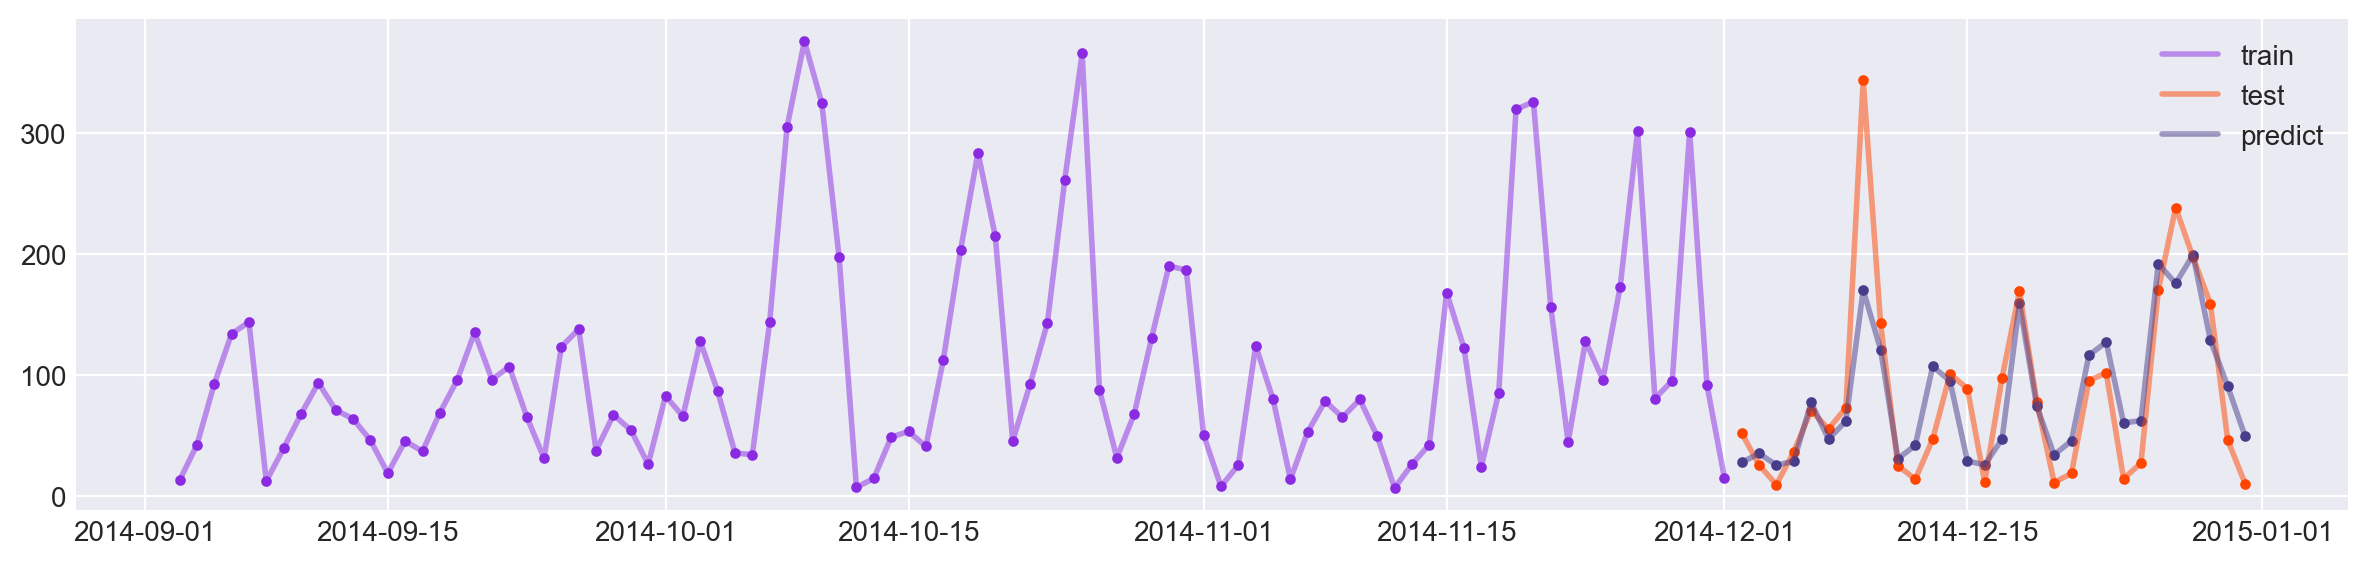

In [21]:
show_series(
    [train_y[-90:], test_y, predictionsDF[model_name]],
    labels=["train", "test", "predict"],
)

In [22]:
print(grid_search_results["params"])

{'l2_leaf_reg': 5}


In [23]:
del (
    train_x,
    train_y,
    test_x,
    test_y,
    train_pool,
    test_pool,
)

### Data Preparation for LSTM

In [24]:
import tensorflow as tf


model, yhat, model_name = None, None, None

model_name = "LSTM_Dense"

WINDOW_LEN = 24
BATCH_SIZE = 64
BUFFER_SIZE = 100
EPOCHS_ = 15


def window_data(X_data, y_data, window_len=7):
    x_, y_ = [], []
    for i in range(window_len - 1, len(X_data)):
        x_.append(X_data[i - window_len + 1 : i + 1])
        y_.append(y_data[i])
    return np.array(x_), np.array(y_)


print(f"dataframe shape {dataframe.shape}")

build_features = lambda df: (
    df.pipe(create_lag_feature, column=TARGET_COLUMN, lags=LAGS)
    .pipe(create_window_feature, column=TARGET_COLUMN, window_len=FEATURE_WINDOW_LEN)
    .pipe(create_datetime_feature, features_name=DT_FEATURES)
    .pipe(create_cyclic_feature, features_name=CYCLIC_FEATURE)
    .pipe(drop_null_rows)
)

df_feat = build_features(dataframe)

print(f"dataframe shape after Feature Union {df_feat.shape}", end="\n\n")

data_x, data_y = seperate_target(df_feat, TARGET_COLUMN)

print(f"data_x shape after seperate_target {data_x.shape}")
print(f"data_y shape after seperate_target {data_y.shape}", end="\n\n")

scaler_x = StandardScaler()
scaler_x.fit(data_x)
data_x_np = scaler_x.transform(data_x)

scaler_y = StandardScaler()
scaler_y.fit(data_y)
data_y_np = scaler_y.transform(data_y)

print(f"data_x shape after StandardScaler {data_x_np.shape}")
print(f"data_y shape after StandardScaler {data_y_np.shape}", end="\n\n")

x_window, y_window = window_data(data_x_np, data_y_np, window_len=WINDOW_LEN)

print(f"x_window shape after Windowing {x_window.shape}")
print(f"y_window shape after Windowing {y_window.shape}", end="\n\n")

x_train_data, x_test_data = x_window[:-TEST_SIZE], x_window[-TEST_SIZE:]
y_train_data, y_test_data = y_window[:-TEST_SIZE], y_window[-TEST_SIZE:]

print(f"x_train_data shape after Test Train Split {x_train_data.shape}")
print(f"x_test_data  shape after Test Train Split {x_test_data.shape}")
print(f"y_train_data shape after Test Train Split {y_train_data.shape}")
print(f"y_test_data  shape after Test Train Split {y_test_data.shape}", end="\n\n")

train_data = (
    tf.data.Dataset.from_tensor_slices((x_train_data, y_train_data))
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
)


test_data = (
    tf.data.Dataset.from_tensor_slices((x_test_data, y_test_data))
    .batch(BATCH_SIZE)
    .repeat()
)

dataframe shape (1825, 7)
dataframe shape after Feature Union (1822, 26)

data_x shape after seperate_target (1822, 25)
data_y shape after seperate_target (1822, 1)

data_x shape after StandardScaler (1822, 25)
data_y shape after StandardScaler (1822, 1)

x_window shape after Windowing (1799, 24, 25)
y_window shape after Windowing (1799, 1)

x_train_data shape after Test Train Split (1769, 24, 25)
x_test_data  shape after Test Train Split (30, 24, 25)
y_train_data shape after Test Train Split (1769, 1)
y_test_data  shape after Test Train Split (30, 1)



In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = tf.keras.models.Sequential(
    [
        LSTM(64, input_shape=x_window.shape[-2:], dropout=0.0, activation="relu"),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(1),
    ]
)

model.compile(optimizer="adam", loss="mse", metrics="mae")

training_history = model.fit(
    train_data,
    epochs=25,
    steps_per_epoch=200,
    validation_data=test_data,
    validation_steps=50,
)
yhat = model.predict(x_test_data)
print(yhat.shape)

Epoch 1/25
200/200 [==============================] - 38s 73ms/step - loss: 0.6082 - mae: 0.5759 - val_loss: 0.5502 - val_mae: 0.4587
Epoch 2/25
200/200 [==============================] - 12s 59ms/step - loss: 0.2851 - mae: 0.3903 - val_loss: 0.3318 - val_mae: 0.3358
Epoch 3/25
200/200 [==============================] - 12s 60ms/step - loss: 0.1949 - mae: 0.3251 - val_loss: 0.3779 - val_mae: 0.3770
Epoch 4/25
200/200 [==============================] - 11s 57ms/step - loss: 0.1953 - mae: 0.3291 - val_loss: 0.3573 - val_mae: 0.4203
Epoch 5/25
200/200 [==============================] - 12s 60ms/step - loss: 0.1346 - mae: 0.2719 - val_loss: 0.3412 - val_mae: 0.3425
Epoch 6/25
200/200 [==============================] - 12s 62ms/step - loss: 0.1339 - mae: 0.2761 - val_loss: 0.3592 - val_mae: 0.3948
Epoch 7/25
200/200 [==============================] - 12s 58ms/step - loss: 0.1202 - mae: 0.2631 - val_loss: 0.5195 - val_mae: 0.5189
Epoch 8/25
200/200 [==============================] - 8s 42ms/

In [36]:
yhat_scaled = scaler_y.inverse_transform(yhat)
y_test_data_scaled = scaler_y.inverse_transform(y_test_data)
y_train_data_scaled = scaler_y.inverse_transform(y_train_data)


print(f"yhat_scaled shape {yhat_scaled.shape} {y_test_data_scaled.shape}")

yhat_scaled shape (30, 1) (30, 1)


In [37]:
resultsDict[model_name] = evaluate(y_test_data_scaled, yhat_scaled)

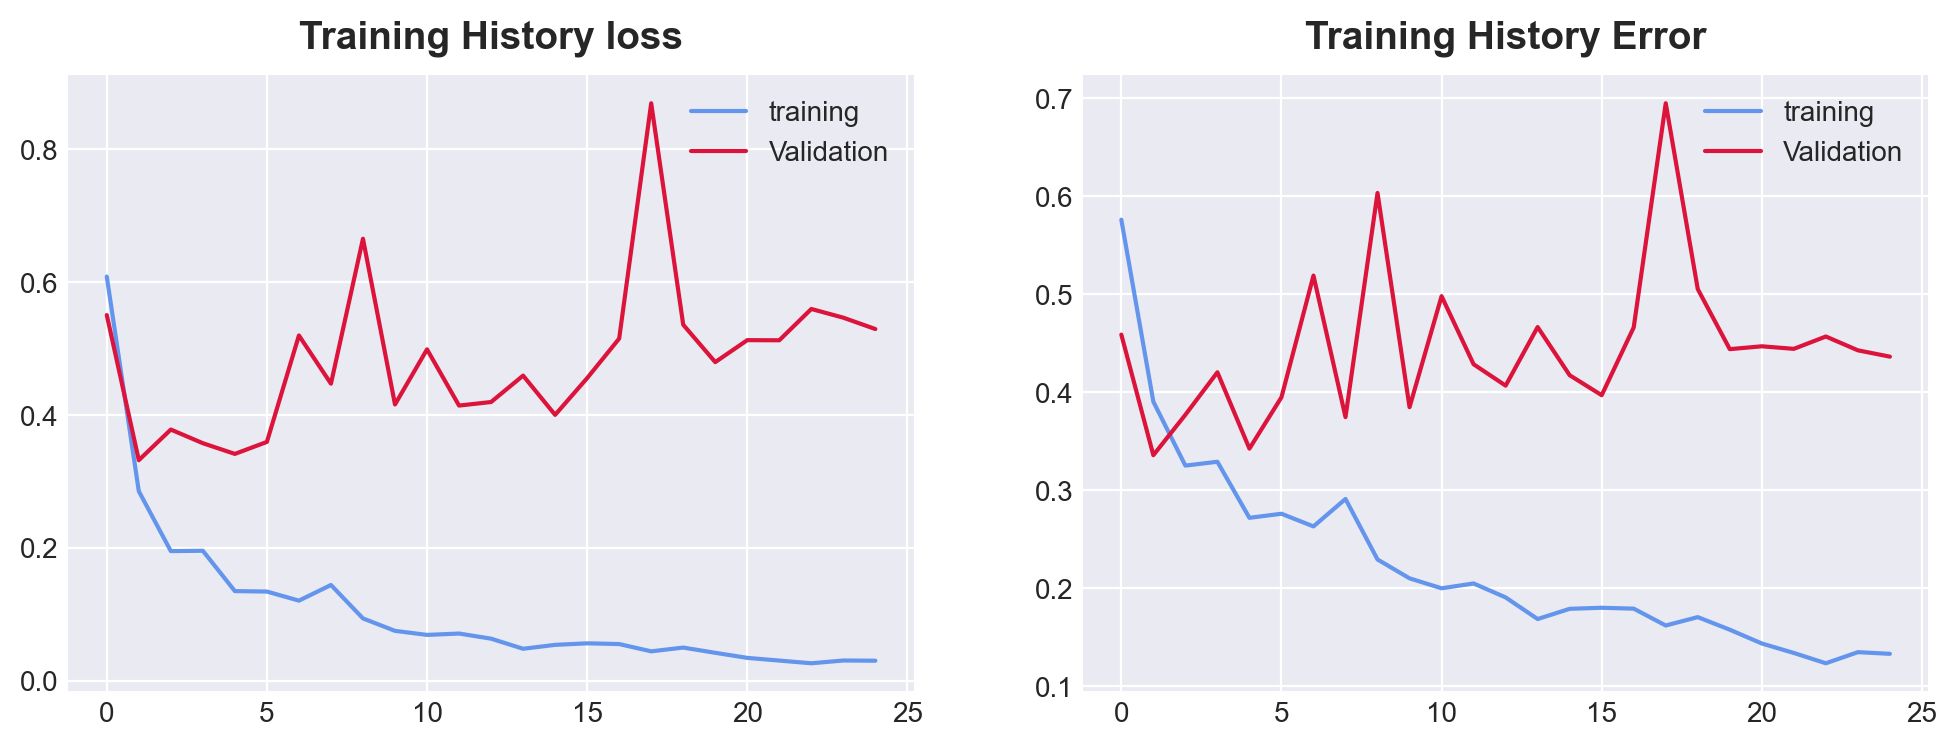

In [38]:
plot_tf_training_history(training_history)

In [39]:
len(y_train_data_scaled)

1769

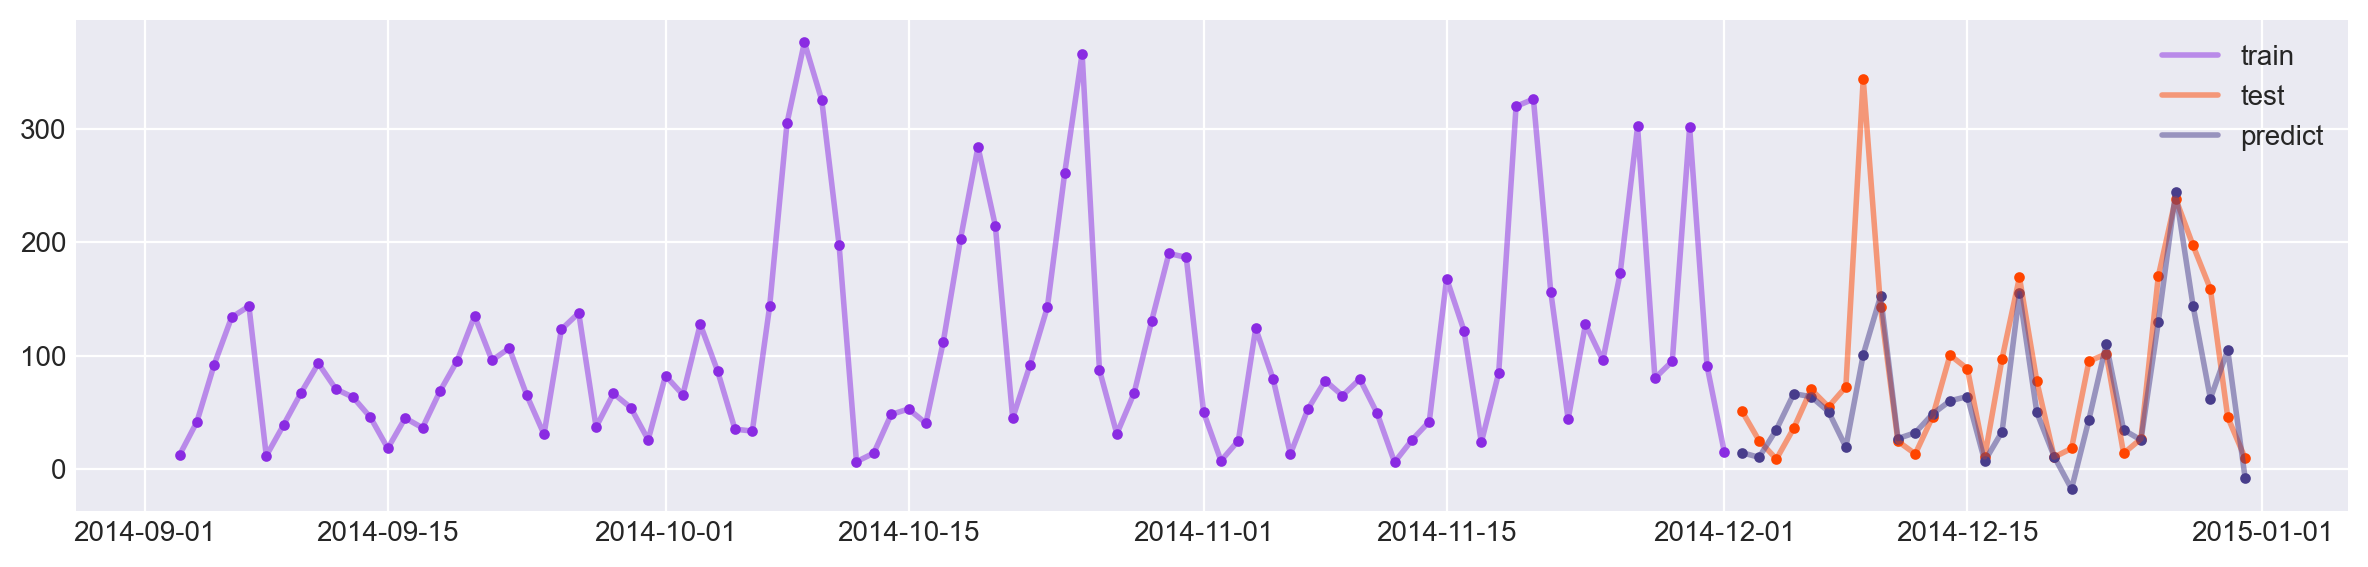

In [40]:
y_hat_df = pd.DataFrame(
    yhat_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_test_data_df = pd.DataFrame(
    y_test_data_scaled, index=data_y.index[-TEST_SIZE:], columns=["TARGET_COLUMN"]
)

y_train_data_df = pd.DataFrame(
    y_train_data_scaled,
    index=data_y.index[WINDOW_LEN - 1 : -TEST_SIZE],
    columns=["TARGET_COLUMN"],
)

show_series(
    [y_train_data_df[-90:], y_test_data_df, y_hat_df],
    labels=["train", "test", "predict"],
)

In [31]:
resultsDF = pd.DataFrame.from_dict(resultsDict)
resultsDF.head()

,KNeighborsRegressor,BayesianRidge,LassoCV,RandomForestRegressor,XGBRegressor,LGBMRegressor,CatBoostRegressor,LSTM_Dense
mae,46.755741,30.747806,31.556739,28.389446,25.980749,28.902388,29.882179,31.602415
rmse,66.880607,52.408958,52.861496,47.277394,43.256398,45.562779,43.760095,45.788707
mape,1.295709,0.535980,0.582134,0.583798,0.544785,0.724443,0.804874,0.526633
r2,0.264849,0.548573,0.540744,0.632647,0.692477,0.658810,0.685274,0.655418


In [32]:
resultsDF.T

,mae,rmse,mape,r2
KNeighborsRegressor,46.755741,66.880607,1.295709,0.264849
BayesianRidge,30.747806,52.408958,0.535980,0.548573
LassoCV,31.556739,52.861496,0.582134,0.540744
RandomForestRegressor,28.389446,47.277394,0.583798,0.632647
XGBRegressor,25.980749,43.256398,0.544785,0.692477
LGBMRegressor,28.902388,45.562779,0.724443,0.658810
CatBoostRegressor,29.882179,43.760095,0.804874,0.685274
LSTM_Dense,31.602415,45.788707,0.526633,0.655418


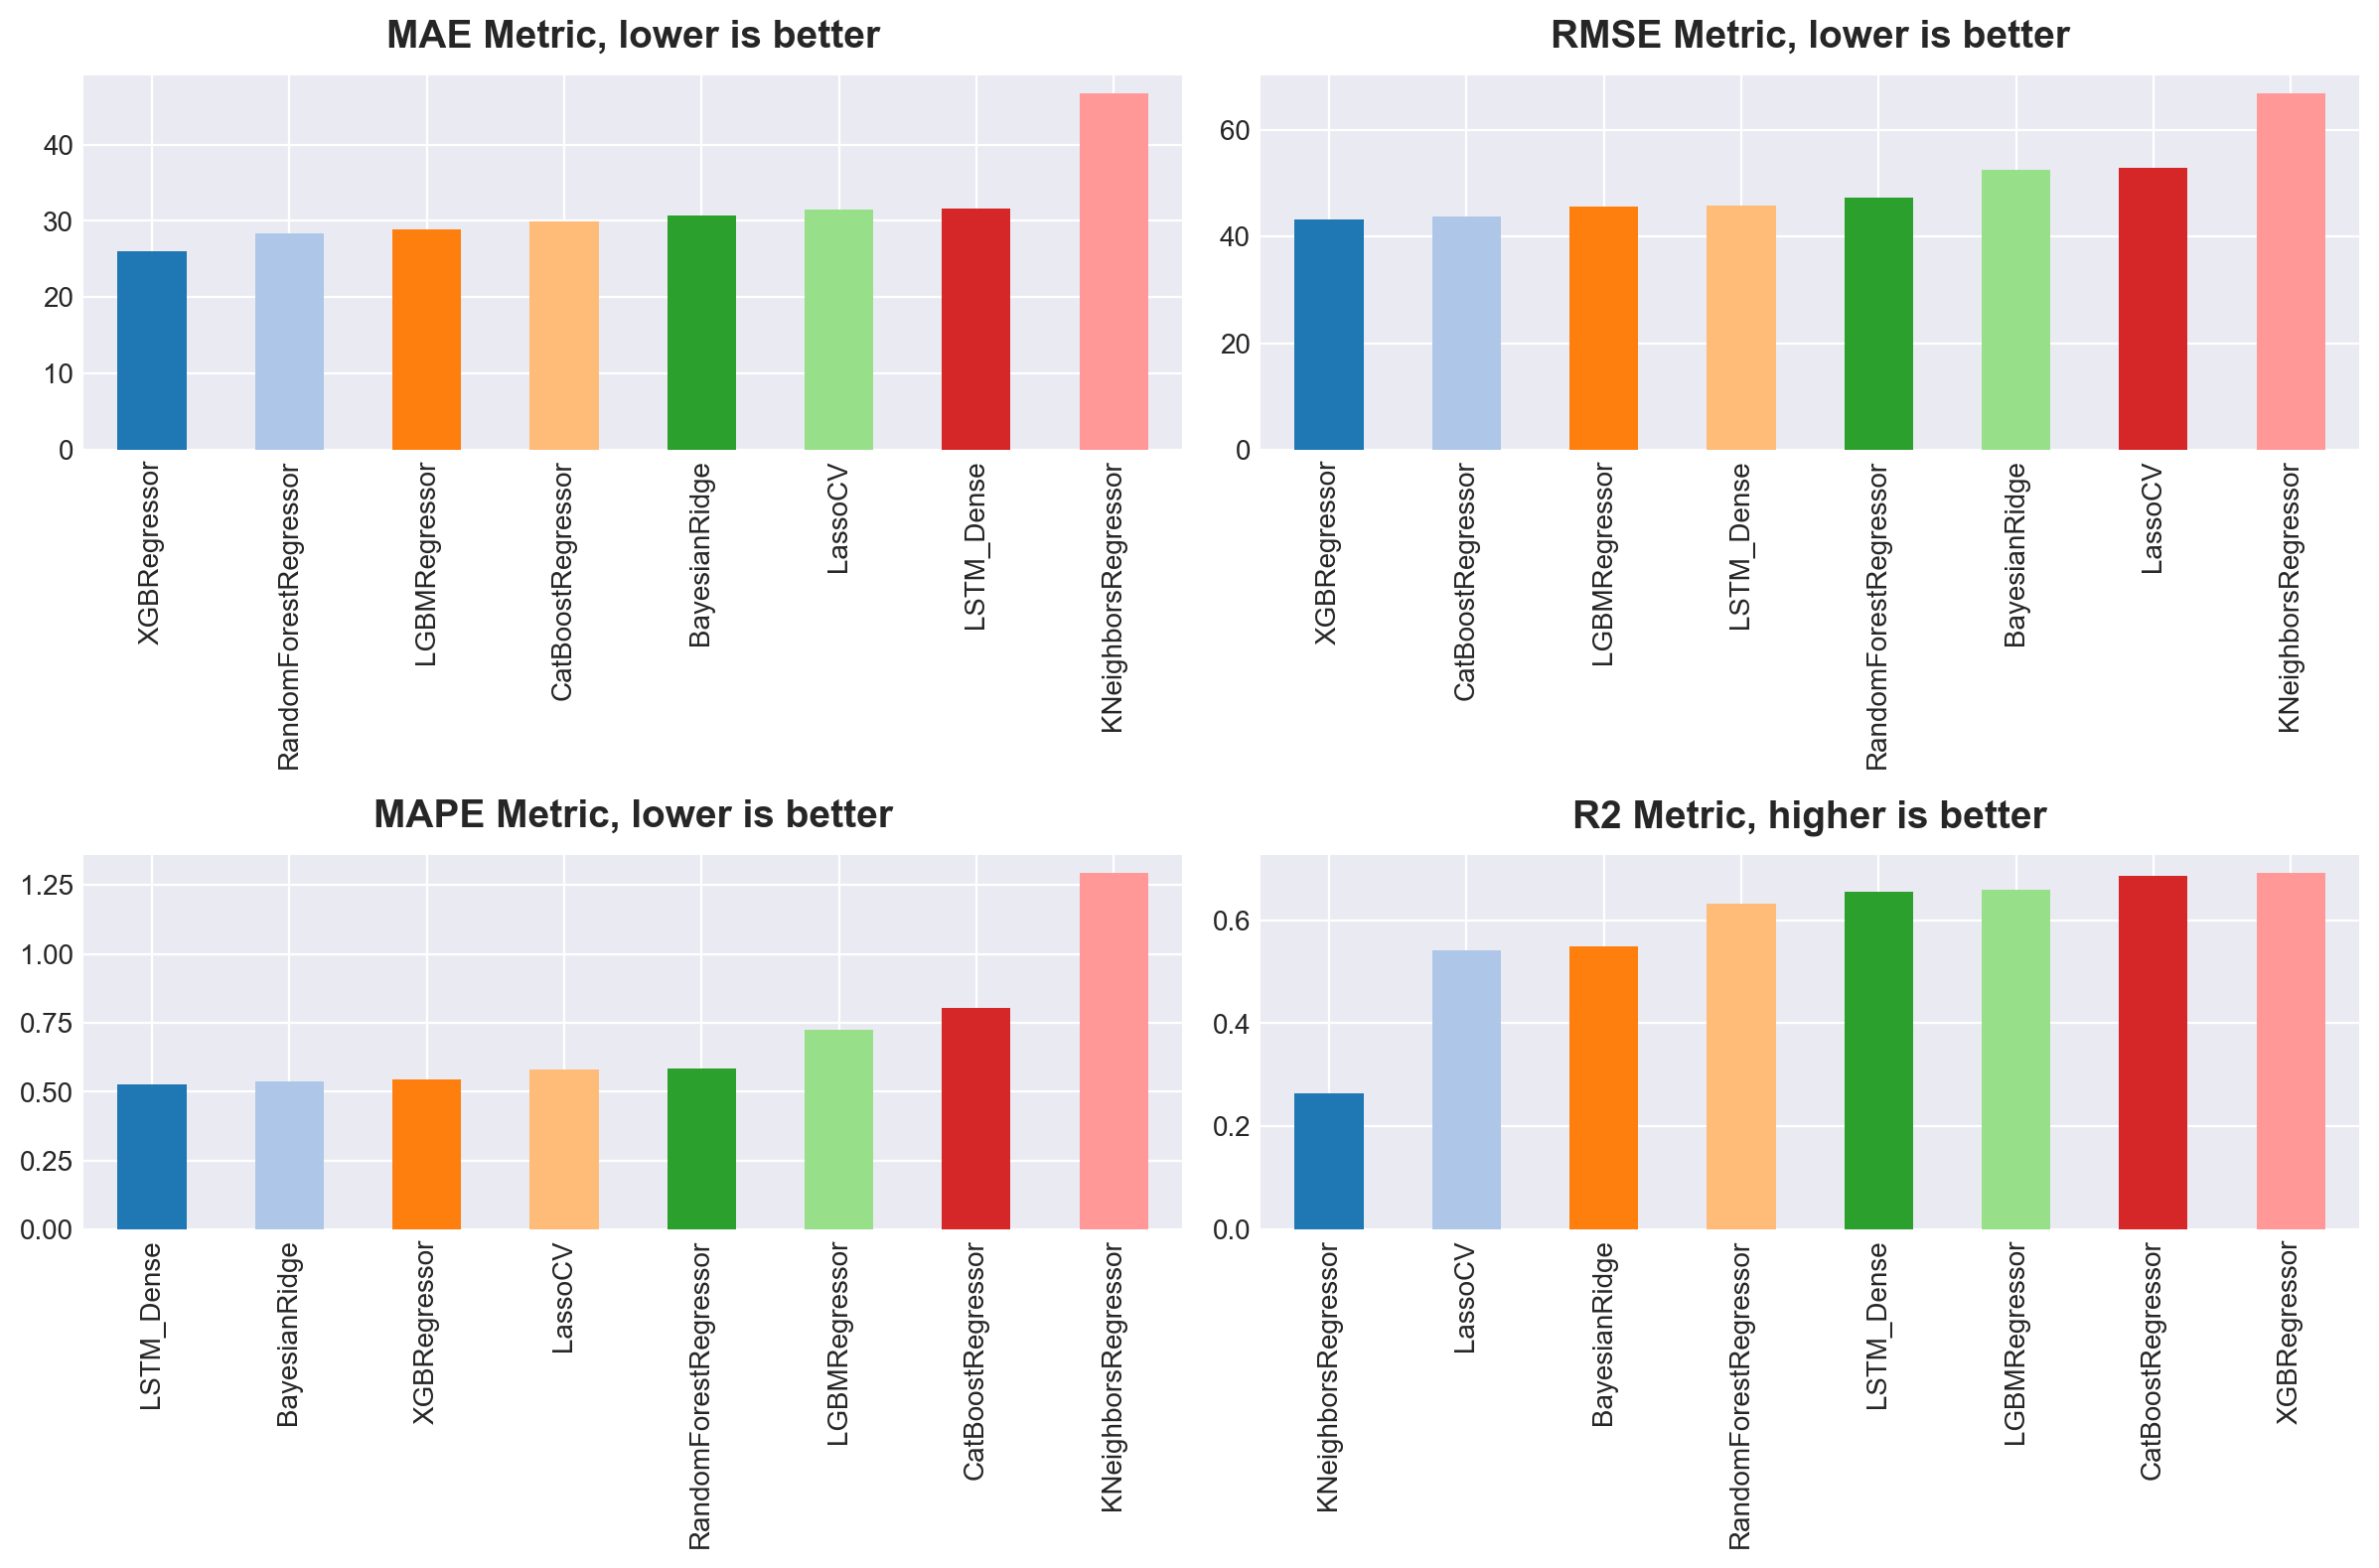

In [33]:
plot_metrics(resultsDF)

In [34]:
resultsDF_T = resultsDF.T.copy(deep=True)

resultsDF_T["Dataset"] = "Air_Polution"
resultsDF_T["Mode"] = "Singel_step"

result_path = "./results/results.csv"


if os.path.isfile(result_path) is False:
    resultsDF_T.to_csv(result_path, index=False)
else:
    result_data = pd.read_csv(result_path)
    if result_data[result_data["Dataset"] == "Air_Polution"].shape[0] > 0:
        result_data = result_data[result_data["Dataset"] != "Air_Polution"].copy()

    new_data = pd.concat([result_data, resultsDF_T])
    new_data.to_csv(result_path, index=False)